# **Fraud Detection Project**  
---
## Project Overview  
This project focuses on predicting fraudulent activity by identifying patterns within a dataset sourced from [OpenML](https://www.openml.org/search?type=data&id=46359&sort=runs&status=active). The primary objective is to predict the `'bad_flag'` feature, which indicates whether a transaction or account is likely to be fraudulent.

Through this analysis, advanced techniques such as XGBoost and neural network models are explored to enhance the detection process. The project also highlights best practices in handling class imbalance, feature engineering, and model evaluation for fraud detection tasks.

---

**Author:** Satria Audria Sakti

**Connect with me:**  
- LinkedIn: 🔗 [satriaaudrias](https://www.linkedin.com/in/satriaaudrias)  
- GitHub: 🐙 [satria4s](https://github.com/satria4s)

---

Let's dive into the project and uncover insights for effective fraud detection! 😊



In [1]:
# ----------------------------------------------------------------------------------- #
# Let's start it by loading the pre-requisites library (either it will be used or not)
# ----------------------------------------------------------------------------------- #

# OpenML Library
!pip install openml
import openml

# Data handler toolkit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Others
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

imported_libraries = [
    openml,
    tf,
    np,
    pd,
    sns
]

for lib in imported_libraries:
    try:
        print(f"{lib.__name__}: {lib.__version__}")
    except AttributeError:
        print(f"{lib.__name__}: Version not found / Library not installed")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.1 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=c94d14bf98a73179736b15102ca66d5139a30e4863c4fe55fe4d4ab1bb0571fe
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


openml: 0.15.0
tensorflow: 2.17.1
numpy: 1.26.4
pandas: 2.2.2
seaborn: 0.13.2


In [158]:
# Then load the dataset using opemML API

# Load the dataset using its ID : 46359
def load_and_display_openml_data(dataset_id):
  """Loads an OpenML dataset and displays its contents using a for loop.

  Args:
    dataset_id: The ID of the OpenML dataset to load.

  Returns:
    A tuple containing the data (X), target (y), categorical indicator, and
    attribute names.
  """
  dataset = openml.datasets.get_dataset(dataset_id)
  X, y, categorical_indicator, attribute_names = dataset.get_data(
      dataset_format="dataframe", target=dataset.default_target_attribute
  )

  print("Dataset:", dataset.name)
  print("Description:", dataset.description)
  print("Default target attribute:", dataset.default_target_attribute)
  print("\nData (X):")
  display(X.head())  # Display the first few rows of the data
  print("\nTarget (y):")
  display(y.head())  # Display the first few rows of the target
  print("\nCategorical Indicator:")
  print(categorical_indicator)  # Print the categorical indicator
  print("\nAttribute Names:")
  print(attribute_names)  # Print the attribute names

  return X, y, categorical_indicator, attribute_names, dataset

# Now load it and display it to view its content
dataset_id = 46359  # Selected dataset id
X, y, categorical_indicator, attribute_names, dataset = load_and_display_openml_data(
    dataset_id
)

# Concatenate X and y into a single DataFrame
df = pd.concat([X, y], axis=1)
df.columns = attribute_names + [dataset.default_target_attribute]  # Set column names

Dataset: Fraud-Detection-Updated
Description: Updated Fraud Detection dataset with nominal target for binary classification.
Default target attribute: bad_flag

Data (X):


dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0        1.0         0.0         0.0              0.0                    6   
1        NaN         NaN         NaN              2.0                    1   
2        NaN         NaN         NaN              1.0                    6   
3        NaN         NaN         NaN              0.0                    5   
4        NaN         NaN         NaN              2.0                    3   

   payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0               0               0               6               0   
1               0               0               0               5   
2               0               0               4               0   
3               0               3               0               0   
4               0               0               6               0   

   payment_type_4  payment_type_5  past_billings_cnt  score_1  score_2  age  \
0               0               0                5.0      NaN      NaN   20   
1               0               0                5.0      NaN      NaN   19   
2               0               0                6.0      NaN      NaN   21   
3               0               0                3.0      NaN      NaN   33   
4               0               0                5.0      NaN      NaN   34   

   gender  rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0       0                2016                    3                 26   
1       0                2016                   10                 30   
2       0                2016                    6                 29   
3       0                2015                   12                  1   
4       0                2016                   10                  1   

   rep_loan_date_weekday  first_loan_year  first_loan_month  first_loan_day  \
0                      2             2015                 9              28   
1                      3             2015                12              21   
2                      6             2015                 6              30   
3                      5             2015                 8               3   
4                      2             2015                 8              30   

   first_loan_weekday  first_overdue_date_year  first_overdue_date_month  \
0                   1                   2016.0                       1.0   
1                   1                      NaN                       NaN   
2                   5                      NaN                       NaN   
3                   1                      NaN                       NaN   
4                   3                      NaN                       NaN   

   first_overdue_date_day  first_overdue_date_weekday  
0                    30.0                           2  
1                     NaN                          -1  
2                     NaN                          -1  
3                     NaN                          -1  
4                     NaN                          -1


Target (y):


0    0
1    0
2    0
3    0
4    0
Name: bad_flag, dtype: category
Categories (2, object): ['0', '1']


Categorical Indicator:
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]

Attribute Names:
['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt', 'federal_district_nm', 'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5', 'past_billings_cnt', 'score_1', 'score_2', 'age', 'gender', 'rep_loan_date_year', 'rep_loan_date_month', 'rep_loan_date_day', 'rep_loan_date_weekday', 'first_loan_year', 'first_loan_month', 'first_loan_day', 'first_loan_weekday', 'first_overdue_date_year', 'first_overdue_date_month', 'first_overdue_date_day', 'first_overdue_date_weekday']


# **Step in to data pre-processing phase**

In [159]:
# Check the data general information
display(df.info())
display(df.describe())

# Now, we're checking the information of the data, wheter there are null/NaN values or not.
col_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'dtype each Columns'})
null_info_nb = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values'})
null_info_pct = pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values in %'})

info_list = [col_info, null_info_nb, null_info_pct]
data_basic_info = pd.concat(info_list, keys=map(lambda x: x.index.name, info_list))
display(data_basic_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dpd_5_cnt                   675 non-null    float64 
 1   dpd_15_cnt                  675 non-null    float64 
 2   dpd_30_cnt                  675 non-null    float64 
 3   close_loans_cnt             4141 non-null   float64 
 4   federal_district_nm         4156 non-null   int64   
 5   payment_type_0              4156 non-null   uint8   
 6   payment_type_1              4156 non-null   uint8   
 7   payment_type_2              4156 non-null   uint8   
 8   payment_type_3              4156 non-null   uint8   
 9   payment_type_4              4156 non-null   uint8   
 10  payment_type_5              4156 non-null   uint8   
 11  past_billings_cnt           3908 non-null   float64 
 12  score_1                     3507 non-null   float64 
 13  score_2           

None

dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  \
count  675.000000  675.000000  675.000000      4141.000000   
mean     1.444444    0.733333    0.280000         1.184255   
std      0.900599    0.764572    0.502339         1.723692   
min      0.000000    0.000000    0.000000         0.000000   
25%      1.000000    0.000000    0.000000         0.000000   
50%      1.000000    1.000000    0.000000         1.000000   
75%      2.000000    1.000000    1.000000         2.000000   
max      7.000000    5.000000    3.000000        31.000000   

       federal_district_nm  payment_type_0  payment_type_1  payment_type_2  \
count          4156.000000     4156.000000     4156.000000     4156.000000   
mean              3.251925        0.018527        0.596246        3.754331   
std               1.727476        0.330399        2.565179        3.809930   
min              -1.000000        0.000000        0.000000        0.000000   
25%               2.000000        0.000000        0.000000        1.000000   
50%               3.000000        0.000000        0.000000        3.000000   
75%               4.000000        0.000000        0.000000        6.000000   
max               7.000000       15.000000       81.000000       33.000000   

       payment_type_3  payment_type_4  payment_type_5  past_billings_cnt  \
count     4156.000000     4156.000000          4156.0        3908.000000   
mean         0.758422        0.019490             0.0           4.977738   
std          2.212722        0.245989             0.0           3.491078   
min          0.000000        0.000000             0.0           1.000000   
25%          0.000000        0.000000             0.0           2.000000   
50%          0.000000        0.000000             0.0           4.000000   
75%          0.000000        0.000000             0.0           6.000000   
max         35.000000        7.000000             0.0          21.000000   

           score_1     score_2          age       gender  rep_loan_date_year  \
count  3507.000000  239.000000  4156.000000  4156.000000         4156.000000   
mean    578.911345  552.546610    34.564485     0.141242         2015.826756   
std      48.989869   21.492840    10.833403     0.348312            0.382299   
min     384.220628  485.874267    18.000000     0.000000         2015.000000   
25%     547.429791  535.545724    26.000000     0.000000         2016.000000   
50%     588.531315  556.757944    32.000000     0.000000         2016.000000   
75%     612.323090  567.608057    41.000000     0.000000         2016.000000   
max     691.528420  603.311653    74.000000     1.000000         2017.000000   

       rep_loan_date_month  rep_loan_date_day  rep_loan_date_weekday  \
count          4156.000000        4156.000000            4156.000000   
mean              7.536092          16.374398               2.917709   
std               3.210377           8.742987               1.913902   
min               1.000000           1.000000               0.000000   
25%               5.000000           9.000000               1.000000   
50%               8.000000          17.000000               3.000000   
75%              10.000000          24.000000               4.250000   
max              12.000000          31.000000               6.000000   

       first_loan_year  first_loan_month  first_loan_day  first_loan_weekday  \
count      4156.000000       4156.000000     4156.000000         4156.000000   
mean       2015.383782          6.671319       16.283927            3.001444   
std           0.486364          3.369897        8.721924            1.977125   
min        2015.000000          1.000000        1.000000            0.000000   
25%        2015.000000          4.000000        9.000000            1.000000   
50%        2015.000000          6.000000       16.000000            3.000000   
75%        2016.000000         10.000000       24.000000            5.000000   
max        2016.000000         12.000000       31.0

dpd_5_cnt dpd_15_cnt dpd_30_cnt close_loans_cnt  \
None dtype each Columns    float64    float64    float64         float64   
     Null Values              3481       3481       3481              15   
     Null Values in %    83.758422  83.758422  83.758422        0.360924   

                        federal_district_nm payment_type_0 payment_type_1  \
None dtype each Columns               int64          uint8          uint8   
     Null Values                          0              0              0   
     Null Values in %                   0.0            0.0            0.0   

                        payment_type_2 payment_type_3 payment_type_4  \
None dtype each Columns          uint8          uint8          uint8   
     Null Values                     0              0              0   
     Null Values in %              0.0            0.0            0.0   

                        payment_type_5 past_billings_cnt    score_1  \
None dtype each Columns          uint8           float64    float64   
     Null Values                     0               248        649   
     Null Values in %              0.0          5.967276  15.615977   

                           score_2    age gender rep_loan_date_year  \
None dtype each Columns    float64  uint8  uint8              int64   
     Null Values              3917      0      0                  0   
     Null Values in %    94.249278    0.0    0.0                0.0   

                        rep_loan_date_month rep_loan_date_day  \
None dtype each Columns               uint8             uint8   
     Null Values                          0                 0   
     Null Values in %                   0.0               0.0   

                        rep_loan_date_weekday first_loan_year  \
None dtype each Columns                 uint8           int64   
     Null Values                            0               0   
     Null Values in %                     0.0             0.0   

                        first_loan_month first_loan_day first_loan_weekday  \
None dtype each Columns            uint8          uint8              uint8   
     Null Values                       0              0                  0   
     Null Values in %                0.0            0.0                0.0   

                        first_overdue_date_year first_overdue_date_month  \
None dtype each Columns                 float64                  float64   
     Null Values                           3481                     3481   
     Null Values in %                 83.758422                83.758422   

                        first_overdue_date_day first_overdue_date_weekday  \
None dtype each Columns                float64                      int64   
     Null Values                          3481                          0   
     Null Values in %                83.758422                        0.0   

                         bad_flag  
None dtype each Columns  category  
     Null Values                0  
     Null Values in %         0.0

As it can be seen above, there are a lot of null values inside, let's just check it out first. <br>
Before continue, check out the `payment_type_5` feature first since it looks very suspicious.

In [160]:
# Get unique values and their counts
unique_values_counts = df['payment_type_5'].value_counts(dropna=False)

# Print the results
print("Unique Values and Counts for payment_type_5:")
print(unique_values_counts)

# Get the total number of unique values (including NaN)
num_unique_values = len(unique_values_counts)
print(f"\nTotal number of unique values (including NaN): {num_unique_values}")

Unique Values and Counts for payment_type_5:
payment_type_5
0    4156
Name: count, dtype: int64

Total number of unique values (including NaN): 1


Well, my suspicion seems to be correct and there are no other value rather than 0 in that feature (It can be means that no account use the payment type 5). Let's just drop it and continue

In [161]:
df = df.drop('payment_type_5', axis=1)

In [162]:
null_rows = df[df.isnull().any(axis=1)]
display(null_rows.head(4))

dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0        1.0         0.0         0.0              0.0                    6   
1        NaN         NaN         NaN              2.0                    1   
2        NaN         NaN         NaN              1.0                    6   
3        NaN         NaN         NaN              0.0                    5   

   payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0               0               0               6               0   
1               0               0               0               5   
2               0               0               4               0   
3               0               3               0               0   

   payment_type_4  past_billings_cnt  score_1  score_2  age  gender  \
0               0                5.0      NaN      NaN   20       0   
1               0                5.0      NaN      NaN   19       0   
2               0                6.0      NaN      NaN   21       0   
3               0                3.0      NaN      NaN   33       0   

   rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0                2016                    3                 26   
1                2016                   10                 30   
2                2016                    6                 29   
3                2015                   12                  1   

   rep_loan_date_weekday  first_loan_year  first_loan_month  first_loan_day  \
0                      2             2015                 9              28   
1                      3             2015                12              21   
2                      6             2015                 6              30   
3                      5             2015                 8               3   

   first_loan_weekday  first_overdue_date_year  first_overdue_date_month  \
0                   1                   2016.0                       1.0   
1                   1                      NaN                       NaN   
2                   5                      NaN                       NaN   
3                   1                      NaN                       NaN   

   first_overdue_date_day  first_overdue_date_weekday bad_flag  
0                    30.0                           2        0  
1                     NaN                          -1        0  
2                     NaN                          -1        0  
3                     NaN                          -1        0

Based on the data above, it can be seen that the DPD (Days Past Due) and x_overdue_date columns with NULL values indicate that the customers/accounts have never been overdue. Therefore, let's impute these values with 0.

In [163]:
# Identify columns with 'dnd' and 'overdue_date' in their names
dpd_columns = [col for col in df.columns if 'dpd' in col]
overdue_date_columns = [col for col in df.columns if 'overdue_date' in col]

# Impute null values with 0 for 'dnd' columns
for col in dpd_columns:
    df[col] = df[col].fillna(0)

# Impute null values with 0 as well for 'overdue_date' columns
for col in overdue_date_columns:
    df[col] = df[col].fillna(0)

df.head(4)

dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0        1.0         0.0         0.0              0.0                    6   
1        0.0         0.0         0.0              2.0                    1   
2        0.0         0.0         0.0              1.0                    6   
3        0.0         0.0         0.0              0.0                    5   

   payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0               0               0               6               0   
1               0               0               0               5   
2               0               0               4               0   
3               0               3               0               0   

   payment_type_4  past_billings_cnt  score_1  score_2  age  gender  \
0               0                5.0      NaN      NaN   20       0   
1               0                5.0      NaN      NaN   19       0   
2               0                6.0      NaN      NaN   21       0   
3               0                3.0      NaN      NaN   33       0   

   rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0                2016                    3                 26   
1                2016                   10                 30   
2                2016                    6                 29   
3                2015                   12                  1   

   rep_loan_date_weekday  first_loan_year  first_loan_month  first_loan_day  \
0                      2             2015                 9              28   
1                      3             2015                12              21   
2                      6             2015                 6              30   
3                      5             2015                 8               3   

   first_loan_weekday  first_overdue_date_year  first_overdue_date_month  \
0                   1                   2016.0                       1.0   
1                   1                      0.0                       0.0   
2                   5                      0.0                       0.0   
3                   1                      0.0                       0.0   

   first_overdue_date_day  first_overdue_date_weekday bad_flag  
0                    30.0                           2        0  
1                     0.0                          -1        0  
2                     0.0                          -1        0  
3                     0.0                          -1        0

As we can see on the table above, the null data have been imputed with 0. Now let's check its general info again.

In [164]:
# Repeat the code above.
col_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'dtype each Columns'})
null_info_nb = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values'})
null_info_pct = pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values in %'})

# Since it has a lot of cols, set display options to show all columns
pd.set_option('display.max_columns', None)

# Display the data
info_list = [col_info, null_info_nb, null_info_pct]
data_basic_info = pd.concat(info_list, keys=map(lambda x: x.index.name, info_list))
display(data_basic_info)

dpd_5_cnt dpd_15_cnt dpd_30_cnt close_loans_cnt  \
None dtype each Columns   float64    float64    float64         float64   
     Null Values                0          0          0              15   
     Null Values in %         0.0        0.0        0.0        0.360924   

                        federal_district_nm payment_type_0 payment_type_1  \
None dtype each Columns               int64          uint8          uint8   
     Null Values                          0              0              0   
     Null Values in %                   0.0            0.0            0.0   

                        payment_type_2 payment_type_3 payment_type_4  \
None dtype each Columns          uint8          uint8          uint8   
     Null Values                     0              0              0   
     Null Values in %              0.0            0.0            0.0   

                        past_billings_cnt    score_1    score_2    age gender  \
None dtype each Columns           float64    float64    float64  uint8  uint8   
     Null Values                      248        649       3917      0      0   
     Null Values in %            5.967276  15.615977  94.249278    0.0    0.0   

                        rep_loan_date_year rep_loan_date_month  \
None dtype each Columns              int64               uint8   
     Null Values                         0                   0   
     Null Values in %                  0.0                 0.0   

                        rep_loan_date_day rep_loan_date_weekday  \
None dtype each Columns             uint8                 uint8   
     Null Values                        0                     0   
     Null Values in %                 0.0                   0.0   

                        first_loan_year first_loan_month first_loan_day  \
None dtype each Columns           int64            uint8          uint8   
     Null Values                      0                0              0   
     Null Values in %               0.0              0.0            0.0   

                        first_loan_weekday first_overdue_date_year  \
None dtype each Columns              uint8                 float64   
     Null Values                         0                       0   
     Null Values in %                  0.0                     0.0   

                        first_overdue_date_month first_overdue_date_day  \
None dtype each Columns                  float64                float64   
     Null Values                               0                      0   
     Null Values in %                        0.0                    0.0   

                        first_overdue_date_weekday  bad_flag  
None dtype each Columns                      int64  category  
     Null Values                                 0         0  
     Null Values in %                          0.0       0.0

Based on the data above, the `score_x` columns have a lot of null values. Let's just try to grab a deeper insight before imputing the data.

In [165]:
# Make a temp dataframe for `score` columns
score_cols = [col for col in df.columns if 'score' in col]

# Display its unq val and null counts
for col in score_cols:
    print(f"Column: {col}")
    print(f"Unique Values: {df[col].unique()}")
    print(f"Null Count: {df[col].isnull().sum()}")
    print("-" * 20)

Column: score_1
Unique Values: [         nan 627.0548439  556.69141251 ... 600.99476302 595.06356968
 644.84981034]
Null Count: 649
--------------------
Column: score_2
Unique Values: [         nan 564.08414145 583.19431983 563.08977997 556.75794443
 572.35699998 554.81692144 550.95771511 505.14546371 546.4394377
 513.51345619 527.58654404 538.16657918 572.8758131  529.21388891
 532.10482145 576.87527738 523.73682896 577.3940905  561.27622183
 559.33519885 521.78631472 553.00336331 535.54572445 518.89538219
 539.3358845  549.33122186 517.26803732 538.43665699 589.52615537
 603.31165277 533.91837958 544.81294446 567.60805737 515.64154407
 542.68485658 548.4850859  556.50503989 515.46397043 598.79337537
 485.87426671 575.14906855 513.41832223 531.06302598 553.98044888
 506.37432406 568.60241885 570.63079114]
Null Count: 3917
--------------------


In [166]:
def print_score_dataframes(df):
  """Prints 4 DataFrames based on score_1 and score_2 values and nulls.

  Args:
    df: The original DataFrame containing score_1 and score_2 columns.
  """

  # Create DataFrames for 'score_1'
  df_score_1_values = df[df['score_1'].notna()].copy()
  df_score_1_nulls = df[df['score_1'].isna()].copy()

  # Create DataFrames for 'score_2'
  df_score_2_values = df[df['score_2'].notna()].copy()
  df_score_2_nulls = df[df['score_2'].isna()].copy()

  # Store DataFrames in a dictionary
  dataframes = {
      "df_score_1_values": df_score_1_values,
      "df_score_1_nulls": df_score_1_nulls,
      "df_score_2_values": df_score_2_values,
      "df_score_2_nulls": df_score_2_nulls
  }

  # Print the DataFrames using a loop
  for name, df_ in dataframes.items():
      print(f"{name}:")
      display(df_)
      print("\n")  # Add a newline for better readability

# Call the function with your DataFrame
print_score_dataframes(df)

df_score_1_values:


dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
84          0.0         0.0         0.0              0.0                    6   
85          0.0         0.0         0.0              0.0                    3   
86          0.0         0.0         0.0              0.0                    6   
87          0.0         0.0         0.0              1.0                    1   
88          1.0         1.0         1.0              3.0                    3   
...         ...         ...         ...              ...                  ...   
4131        1.0         1.0         1.0              0.0                    2   
4133        0.0         0.0         0.0              1.0                    2   
4134        0.0         0.0         0.0              0.0                    3   
4137        3.0         2.0         1.0              2.0                    6   
4138        0.0         0.0         0.0              1.0                    2   

      payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
84                 0               0               1               0   
85                 0               0               1               0   
86                 0               0               1               0   
87                 0               0               6               0   
88                 0               0               8               3   
...              ...             ...             ...             ...   
4131               0               0               0               3   
4133               0               0               3               3   
4134               0               0               4               0   
4137               0               0               8               0   
4138               0               0               3               0   

      payment_type_4  past_billings_cnt     score_1  score_2  age  gender  \
84                 0                NaN  627.054844      NaN   30       0   
85                 0                NaN  556.691413      NaN   25       1   
86                 0                NaN  546.752158      NaN   40       1   
87                 0                6.0  544.179351      NaN   43       0   
88                 0                9.0  509.907060      NaN   34       0   
...              ...                ...         ...      ...  ...     ...   
4131               0                3.0  491.288733      NaN   26       0   
4133               0                5.0  618.123300      NaN   59       0   
4134               0                5.0  592.717366      NaN   25       1   
4137               0                6.0  542.398397      NaN   28       0   
4138               0                3.0  644.849810      NaN   39       0   

      rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
84                  2016                   10                  3   
85                  2016                   10                  2   
86                  2016                    9                 29   
87                  2016                    9                 27   
88                  2016                    8                 29   
...                  ...                  ...                ...   
4131                2016                    3                 24   
4133                2016                    6                  4   
4134                2015                   12                 30   
4137                2016                   10                 11   
4138                2016                    1                 28   

      rep_loan_date_weekday  first_loan_year  first_loan_month  \
84                        1             2016                 9   
85                        3             2016                 9   
86                        4             2016                 9   
87                        5             2015                10   
88                        1             2015                11   
...                     ...   



df_score_1_nulls:


dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0           1.0         0.0         0.0              0.0                    6   
1           0.0         0.0         0.0              2.0                    1   
2           0.0         0.0         0.0              1.0                    6   
3           0.0         0.0         0.0              0.0                    5   
4           0.0         0.0         0.0              2.0                    3   
...         ...         ...         ...              ...                  ...   
4151        0.0         0.0         0.0              0.0                    5   
4152        0.0         0.0         0.0              1.0                    2   
4153        0.0         0.0         0.0              1.0                    2   
4154        0.0         0.0         0.0              0.0                    6   
4155        2.0         2.0         0.0              0.0                    4   

      payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0                  0               0               6               0   
1                  0               0               0               5   
2                  0               0               4               0   
3                  0               3               0               0   
4                  0               0               6               0   
...              ...             ...             ...             ...   
4151               0               0               1               0   
4152               0               0               4               0   
4153               0               0               4               0   
4154               0               0               4               0   
4155               0               0               6               0   

      payment_type_4  past_billings_cnt  score_1     score_2  age  gender  \
0                  0                5.0      NaN         NaN   20       0   
1                  0                5.0      NaN         NaN   19       0   
2                  0                6.0      NaN         NaN   21       0   
3                  0                3.0      NaN         NaN   33       0   
4                  0                5.0      NaN         NaN   34       0   
...              ...                ...      ...         ...  ...     ...   
4151               0                NaN      NaN  563.089780   26       0   
4152               0                3.0      NaN  576.875277   38       0   
4153               0                4.0      NaN  554.816921   21       0   
4154               0                4.0      NaN  563.089780   35       0   
4155               0                5.0      NaN         NaN   25       0   

      rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0                   2016                    3                 26   
1                   2016                   10                 30   
2                   2016                    6                 29   
3                   2015                   12                  1   
4                   2016                   10                  1   
...                  ...                  ...                ...   
4151                2016                    6                 11   
4152                2016                    8                  6   
4153                2016                    9                  5   
4154                2016                   10                 14   
4155                2016                    6                  2   

      rep_loan_date_weekday  first_loan_year  first_loan_month  \
0                         2             2015                 9   
1                         3             2015                12   
2                         6             2015                 6   
3                         5             2015                 8   
4                         2             2015                 8   
...                     ...   



df_score_2_values:


dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
30          1.0         0.0         0.0              1.0                    2   
33          0.0         0.0         0.0              1.0                    4   
40          2.0         1.0         0.0              1.0                    3   
44          0.0         0.0         0.0              1.0                    2   
47          0.0         0.0         0.0              1.0                    4   
...         ...         ...         ...              ...                  ...   
4150        1.0         1.0         1.0              0.0                    3   
4151        0.0         0.0         0.0              0.0                    5   
4152        0.0         0.0         0.0              1.0                    2   
4153        0.0         0.0         0.0              1.0                    2   
4154        0.0         0.0         0.0              0.0                    6   

      payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
30                 0               0               0               3   
33                 0               0               3               0   
40                 0               0               6               0   
44                 0               0               0               3   
47                 0               0               0               3   
...              ...             ...             ...             ...   
4150               0               0               1               0   
4151               0               0               1               0   
4152               0               0               4               0   
4153               0               0               4               0   
4154               0               0               4               0   

      payment_type_4  past_billings_cnt  score_1     score_2  age  gender  \
30                 0                3.0      NaN  564.084141   23       0   
33                 0                3.0      NaN  583.194320   59       0   
40                 0                6.0      NaN  583.194320   54       0   
44                 0                3.0      NaN  563.089780   25       0   
47                 0                3.0      NaN  556.757944   32       0   
...              ...                ...      ...         ...  ...     ...   
4150               0                2.0      NaN  518.895382   19       0   
4151               0                NaN      NaN  563.089780   26       0   
4152               0                3.0      NaN  576.875277   38       0   
4153               0                4.0      NaN  554.816921   21       0   
4154               0                4.0      NaN  563.089780   35       0   

      rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
30                  2016                    7                 11   
33                  2016                    9                  7   
40                  2016                   10                  5   
44                  2016                   10                 13   
47                  2016                    9                 24   
...                  ...                  ...                ...   
4150                2016                    8                 26   
4151                2016                    6                 11   
4152                2016                    8                  6   
4153                2016                    9                  5   
4154                2016                   10                 14   

      rep_loan_date_weekday  first_loan_year  first_loan_month  \
30                        1             2016                 3   
33                        6             2016                 2   
40                        6             2016                 1   
44                        4             2016                 4   
47                        2             2016                 2   
...                     ...   



df_score_2_nulls:


dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0           1.0         0.0         0.0              0.0                    6   
1           0.0         0.0         0.0              2.0                    1   
2           0.0         0.0         0.0              1.0                    6   
3           0.0         0.0         0.0              0.0                    5   
4           0.0         0.0         0.0              2.0                    3   
...         ...         ...         ...              ...                  ...   
4137        3.0         2.0         1.0              2.0                    6   
4138        0.0         0.0         0.0              1.0                    2   
4145        1.0         0.0         0.0              1.0                    0   
4149        0.0         0.0         0.0              0.0                    3   
4155        2.0         2.0         0.0              0.0                    4   

      payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0                  0               0               6               0   
1                  0               0               0               5   
2                  0               0               4               0   
3                  0               3               0               0   
4                  0               0               6               0   
...              ...             ...             ...             ...   
4137               0               0               8               0   
4138               0               0               3               0   
4145               0               0               3               0   
4149               0               0               2               0   
4155               0               0               6               0   

      payment_type_4  past_billings_cnt     score_1  score_2  age  gender  \
0                  0                5.0         NaN      NaN   20       0   
1                  0                5.0         NaN      NaN   19       0   
2                  0                6.0         NaN      NaN   21       0   
3                  0                3.0         NaN      NaN   33       0   
4                  0                5.0         NaN      NaN   34       0   
...              ...                ...         ...      ...  ...     ...   
4137               0                6.0  542.398397      NaN   28       0   
4138               0                3.0  644.849810      NaN   39       0   
4145               0                3.0         NaN      NaN   21       0   
4149               0                1.0         NaN      NaN   18       0   
4155               0                5.0         NaN      NaN   25       0   

      rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0                   2016                    3                 26   
1                   2016                   10                 30   
2                   2016                    6                 29   
3                   2015                   12                  1   
4                   2016                   10                  1   
...                  ...                  ...                ...   
4137                2016                   10                 11   
4138                2016                    1                 28   
4145                2015                    9                 22   
4149                2015                    7                 23   
4155                2016                    6                  2   

      rep_loan_date_weekday  first_loan_year  first_loan_month  \
0                         2             2015                 9   
1                         3             2015                12   
2                         6             2015                 6   
3                         5             2015                 8   
4                         2             2015                 8   
...                     ...   

Check out null values within both scores column.

In [167]:
# Set new temp dataframe
null_in_both_scores = df[(df['score_1'].isnull()) & (df['score_2'].isnull())]

# Print the number of rows with nulls in both columns
print(f"Number of rows with nulls in both score columns: {len(null_in_both_scores)}")

# Display the rows with nulls in both columns (optional)
display(null_in_both_scores)

Number of rows with nulls in both score columns: 410


dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0           1.0         0.0         0.0              0.0                    6   
1           0.0         0.0         0.0              2.0                    1   
2           0.0         0.0         0.0              1.0                    6   
3           0.0         0.0         0.0              0.0                    5   
4           0.0         0.0         0.0              2.0                    3   
...         ...         ...         ...              ...                  ...   
4046        0.0         0.0         0.0              1.0                    6   
4062        1.0         0.0         0.0              1.0                    7   
4145        1.0         0.0         0.0              1.0                    0   
4149        0.0         0.0         0.0              0.0                    3   
4155        2.0         2.0         0.0              0.0                    4   

      payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0                  0               0               6               0   
1                  0               0               0               5   
2                  0               0               4               0   
3                  0               3               0               0   
4                  0               0               6               0   
...              ...             ...             ...             ...   
4046               0               6               0               0   
4062               0               2               0               1   
4145               0               0               3               0   
4149               0               0               2               0   
4155               0               0               6               0   

      payment_type_4  past_billings_cnt  score_1  score_2  age  gender  \
0                  0                5.0      NaN      NaN   20       0   
1                  0                5.0      NaN      NaN   19       0   
2                  0                6.0      NaN      NaN   21       0   
3                  0                3.0      NaN      NaN   33       0   
4                  0                5.0      NaN      NaN   34       0   
...              ...                ...      ...      ...  ...     ...   
4046               0                6.0      NaN      NaN   20       0   
4062               0                3.0      NaN      NaN   31       1   
4145               0                3.0      NaN      NaN   21       0   
4149               0                1.0      NaN      NaN   18       0   
4155               0                5.0      NaN      NaN   25       0   

      rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0                   2016                    3                 26   
1                   2016                   10                 30   
2                   2016                    6                 29   
3                   2015                   12                  1   
4                   2016                   10                  1   
...                  ...                  ...                ...   
4046                2016                   11                 29   
4062                2016                    5                 26   
4145                2015                    9                 22   
4149                2015                    7                 23   
4155                2016                    6                  2   

      rep_loan_date_weekday  first_loan_year  first_loan_month  \
0                         2             2015                 9   
1                         3             2015                12   
2                         6             2015                 6   
3                         5             2015                 8   
4                         2             2015                 8   
...                     ...              ...               ...   


**<font size="+2"> Score columns explanation based on the data above</font>**


* The scoring data has been divided into Type 1 and Type 2 scores (previously can be stored as a dictionary) and splitted into two separate columns.
* Some of customer accounts have not been scored yet (both of `score` columns contain NULL values).
* Imputing with a value of -1 will provide greater clarity, indicating that the scoring process has not been completed.


In [168]:
# Impute null values with -1 for both score columns
df['score_1'] = df['score_1'].fillna(-1)
df['score_2'] = df['score_2'].fillna(-1)

# Repeat the code above.
col_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'dtype each Columns'})
null_info_nb = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values'})
null_info_pct = pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values in %'})

# Since it has a lot of cols, set display options to show all columns
pd.set_option('display.max_columns', None)

# Display the data
info_list = [col_info, null_info_nb, null_info_pct]
data_basic_info = pd.concat(info_list, keys=map(lambda x: x.index.name, info_list))
display(data_basic_info)

dpd_5_cnt dpd_15_cnt dpd_30_cnt close_loans_cnt  \
None dtype each Columns   float64    float64    float64         float64   
     Null Values                0          0          0              15   
     Null Values in %         0.0        0.0        0.0        0.360924   

                        federal_district_nm payment_type_0 payment_type_1  \
None dtype each Columns               int64          uint8          uint8   
     Null Values                          0              0              0   
     Null Values in %                   0.0            0.0            0.0   

                        payment_type_2 payment_type_3 payment_type_4  \
None dtype each Columns          uint8          uint8          uint8   
     Null Values                     0              0              0   
     Null Values in %              0.0            0.0            0.0   

                        past_billings_cnt  score_1  score_2    age gender  \
None dtype each Columns           float64  float64  float64  uint8  uint8   
     Null Values                      248        0        0      0      0   
     Null Values in %            5.967276      0.0      0.0    0.0    0.0   

                        rep_loan_date_year rep_loan_date_month  \
None dtype each Columns              int64               uint8   
     Null Values                         0                   0   
     Null Values in %                  0.0                 0.0   

                        rep_loan_date_day rep_loan_date_weekday  \
None dtype each Columns             uint8                 uint8   
     Null Values                        0                     0   
     Null Values in %                 0.0                   0.0   

                        first_loan_year first_loan_month first_loan_day  \
None dtype each Columns           int64            uint8          uint8   
     Null Values                      0                0              0   
     Null Values in %               0.0              0.0            0.0   

                        first_loan_weekday first_overdue_date_year  \
None dtype each Columns              uint8                 float64   
     Null Values                         0                       0   
     Null Values in %                  0.0                     0.0   

                        first_overdue_date_month first_overdue_date_day  \
None dtype each Columns                  float64                float64   
     Null Values                               0                      0   
     Null Values in %                        0.0                    0.0   

                        first_overdue_date_weekday  bad_flag  
None dtype each Columns                      int64  category  
     Null Values                                 0         0  
     Null Values in %                          0.0       0.0

Great, it's getting better and now let's just identify the rest of the columnsn with null values.

In [169]:
null_columns = df.columns[df.isnull().any()]
temp_null = df[null_columns].copy()
null_counts = temp_null.isna().sum()

# Print out null values
for column, count in null_counts.items():
       print(f"Null values in column {column} is {count}")

# Print out the null ratio
total_rows = len(temp_null)
for column, count in null_counts.items():
       ratio = (count / total_rows) * 100  # Calculate percentage
       print(f"Null values ratio in column {column}: {ratio:.2f}%")

# Print out rows without NULL values
not_null_rows = temp_null[temp_null.notnull().any(axis=1)]
display(not_null_rows)

# Print out rows with NULL values
null_rows = temp_null[temp_null.isnull().any(axis=1)]
display(null_rows)

Null values in column close_loans_cnt is 15
Null values in column past_billings_cnt is 248
Null values ratio in column close_loans_cnt: 0.36%
Null values ratio in column past_billings_cnt: 5.97%


close_loans_cnt  past_billings_cnt
0                 0.0                5.0
1                 2.0                5.0
2                 1.0                6.0
3                 0.0                3.0
4                 2.0                5.0
...               ...                ...
4151              0.0                NaN
4152              1.0                3.0
4153              1.0                4.0
4154              0.0                4.0
4155              0.0                5.0

[4141 rows x 2 columns]

close_loans_cnt  past_billings_cnt
42                0.0                NaN
54                NaN                NaN
56                0.0                NaN
74                0.0                NaN
84                0.0                NaN
...               ...                ...
4110              1.0                NaN
4111              0.0                NaN
4123              0.0                NaN
4141              0.0                NaN
4151              0.0                NaN

[248 rows x 2 columns]

Based on the information above, let's impute NULL Values inside the `close_loans_cnt` column with 0 since the percentages isn't that much, and for the `past_billings_cnt`, impute its value using KNN Imputer.

In [170]:
# Imputation for `close_loans_cnt` column
df['close_loans_cnt'] = df['close_loans_cnt'].fillna(0)

# Imputation for `past_billings_cnt` column
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)  # Experiment with different values for n_neighbors (recommended 3-5)
df['past_billings_cnt'] = imputer.fit_transform(df[['past_billings_cnt']])

# Repeat the code above.
col_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'dtype each Columns'})
null_info_nb = pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Null Values'})
null_info_pct = pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Null Values in %'})

# Since it has a lot of cols, set display options to show all columns
pd.set_option('display.max_columns', None)

# Display the data
info_list = [col_info, null_info_nb, null_info_pct]
data_basic_info = pd.concat(info_list, keys=map(lambda x: x.index.name, info_list))
display(data_basic_info)

dpd_5_cnt dpd_15_cnt dpd_30_cnt close_loans_cnt  \
None dtype each Columns   float64    float64    float64         float64   
     Null Values                0          0          0               0   
     Null Values in %         0.0        0.0        0.0             0.0   

                        federal_district_nm payment_type_0 payment_type_1  \
None dtype each Columns               int64          uint8          uint8   
     Null Values                          0              0              0   
     Null Values in %                   0.0            0.0            0.0   

                        payment_type_2 payment_type_3 payment_type_4  \
None dtype each Columns          uint8          uint8          uint8   
     Null Values                     0              0              0   
     Null Values in %              0.0            0.0            0.0   

                        past_billings_cnt  score_1  score_2    age gender  \
None dtype each Columns           float64  float64  float64  uint8  uint8   
     Null Values                        0        0        0      0      0   
     Null Values in %                 0.0      0.0      0.0    0.0    0.0   

                        rep_loan_date_year rep_loan_date_month  \
None dtype each Columns              int64               uint8   
     Null Values                         0                   0   
     Null Values in %                  0.0                 0.0   

                        rep_loan_date_day rep_loan_date_weekday  \
None dtype each Columns             uint8                 uint8   
     Null Values                        0                     0   
     Null Values in %                 0.0                   0.0   

                        first_loan_year first_loan_month first_loan_day  \
None dtype each Columns           int64            uint8          uint8   
     Null Values                      0                0              0   
     Null Values in %               0.0              0.0            0.0   

                        first_loan_weekday first_overdue_date_year  \
None dtype each Columns              uint8                 float64   
     Null Values                         0                       0   
     Null Values in %                  0.0                     0.0   

                        first_overdue_date_month first_overdue_date_day  \
None dtype each Columns                  float64                float64   
     Null Values                               0                      0   
     Null Values in %                        0.0                    0.0   

                        first_overdue_date_weekday  bad_flag  
None dtype each Columns                      int64  category  
     Null Values                                 0         0  
     Null Values in %                          0.0       0.0

Great, no more NULL values within the data. Now let's check out the outliers inside the data using IQR, and do something with it.

In [171]:
# Check out unique values each features and count it
for column in df.columns:
    unique_values = df[column].unique()
    unique_value_counts = df[column].value_counts()

    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print("Unique Values Count:")

    # Format and print the value counts
    for value, count in unique_value_counts.items():
        print(f"  {value}: {count}")

    print("-" * 66)  # Separator for better readability

Column: dpd_5_cnt
Unique Values: [1. 0. 3. 2. 4. 5. 6. 7.]
Unique Values Count:
  0.0: 3485
  1.0: 484
  2.0: 114
  3.0: 47
  4.0: 14
  5.0: 7
  6.0: 4
  7.0: 1
------------------------------------------------------------------
Column: dpd_15_cnt
Unique Values: [0. 1. 2. 3. 4. 5.]
Unique Values Count:
  0.0: 3762
  1.0: 314
  2.0: 66
  3.0: 9
  4.0: 3
  5.0: 2
------------------------------------------------------------------
Column: dpd_30_cnt
Unique Values: [0. 1. 2. 3.]
Unique Values Count:
  0.0: 3983
  1.0: 158
  2.0: 14
  3.0: 1
------------------------------------------------------------------
Column: close_loans_cnt
Unique Values: [ 0.  2.  1.  3.  4. 10.  5.  6.  7.  8. 11.  9. 14. 17. 16. 12. 13. 15.
 18. 31. 19.]
Unique Values Count:
  0.0: 1687
  1.0: 1358
  2.0: 587
  3.0: 239
  4.0: 122
  5.0: 64
  6.0: 33
  7.0: 23
  8.0: 12
  9.0: 9
  10.0: 5
  11.0: 4
  14.0: 2
  17.0: 2
  13.0: 2
  18.0: 2
  16.0: 1
  12.0: 1
  15.0: 1
  31.0: 1
  19.0: 1
-----------------------------

Let's just focus on the outliers now

In [172]:
# Define a function to detect the outliers
def detect_outliers_iqr(data, features):
    """Detects outliers using the IQR method.

    Args:
        data: The input DataFrame.
        features: A list of numerical features to check for outliers.

    Returns:
        A dictionary where keys are feature names and values are lists of outlier indices.
    """

    outlier_indices = {}
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].index
        outlier_indices[feature] = outliers

    return outlier_indices

# Get numerical features (excluding the target variable)
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
#numerical_features.remove('bad_flag')  # Remove target variable, but since the bad_flag data was
                                        # already categorical, skip it
print(f"Here's the features that will be used as X (exclude the target/Y)")
print("~~~" * 33)
display(numerical_features)

# Detect outliers
outlier_indices = detect_outliers_iqr(df, numerical_features)

print("~~~" * 33)
print(f"Here's every outliers that have been found through the IQR method")
# Print out the results
for feature, outliers in outlier_indices.items():
    if len(outliers) > 0:
        print(f"Feature {feature}: {len(outliers)} outliers were found!")

Here's the features that will be used as X (exclude the target/Y)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


['dpd_5_cnt',
 'dpd_15_cnt',
 'dpd_30_cnt',
 'close_loans_cnt',
 'federal_district_nm',
 'payment_type_0',
 'payment_type_1',
 'payment_type_2',
 'payment_type_3',
 'payment_type_4',
 'past_billings_cnt',
 'score_1',
 'score_2',
 'age',
 'gender',
 'rep_loan_date_year',
 'rep_loan_date_month',
 'rep_loan_date_day',
 'rep_loan_date_weekday',
 'first_loan_year',
 'first_loan_month',
 'first_loan_day',
 'first_loan_weekday',
 'first_overdue_date_year',
 'first_overdue_date_month',
 'first_overdue_date_day',
 'first_overdue_date_weekday']

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Here's every outliers that have been found through the IQR method
Feature dpd_5_cnt: 671 outliers were found!
Feature dpd_15_cnt: 394 outliers were found!
Feature dpd_30_cnt: 173 outliers were found!
Feature close_loans_cnt: 99 outliers were found!
Feature payment_type_0: 28 outliers were found!
Feature payment_type_1: 521 outliers were found!
Feature payment_type_2: 108 outliers were found!
Feature payment_type_3: 805 outliers were found!
Feature payment_type_4: 41 outliers were found!
Feature past_billings_cnt: 309 outliers were found!
Feature score_1: 649 outliers were found!
Feature score_2: 239 outliers were found!
Feature age: 23 outliers were found!
Feature gender: 587 outliers were found!
Feature rep_loan_date_year: 732 outliers were found!
Feature first_overdue_date_year: 675 outliers were found!
Feature first_overdue_date_month: 675 outliers were found!
Feature first_overdue_da

In [173]:
# Handle outliers (e.g., by removing or capping)
# Option 1: Remove outliers
# for feature, outliers in outlier_indices.items():
#     df = df.drop(index=outliers)

# I'll go with the Option 2 since, I don't want to throw any important data that might have the outliers
# Option 2: Cap outliers (winsorizing)
df_capped = df.copy()
for feature, outliers in outlier_indices.items():
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_capped.loc[outliers, feature] = np.clip(df.loc[outliers, feature], lower_bound, upper_bound)

In [174]:
# Detect outliers in df_capped
outlier_indices_capped = detect_outliers_iqr(df_capped, numerical_features)

# Print out the results for df_capped
for feature, outliers in outlier_indices_capped.items():
    if len(outliers) > 0:
        print(f"Feature {feature} in df_capped: {len(outliers)} outliers were found!")
    else:
        print(f"Feature {feature} in df_capped: No outliers were found!")

Feature dpd_5_cnt in df_capped: No outliers were found!
Feature dpd_15_cnt in df_capped: No outliers were found!
Feature dpd_30_cnt in df_capped: No outliers were found!
Feature close_loans_cnt in df_capped: No outliers were found!
Feature federal_district_nm in df_capped: No outliers were found!
Feature payment_type_0 in df_capped: No outliers were found!
Feature payment_type_1 in df_capped: No outliers were found!
Feature payment_type_2 in df_capped: No outliers were found!
Feature payment_type_3 in df_capped: No outliers were found!
Feature payment_type_4 in df_capped: No outliers were found!
Feature past_billings_cnt in df_capped: No outliers were found!
Feature score_1 in df_capped: No outliers were found!
Feature score_2 in df_capped: No outliers were found!
Feature age in df_capped: No outliers were found!
Feature gender in df_capped: No outliers were found!
Feature rep_loan_date_year in df_capped: No outliers were found!
Feature rep_loan_date_month in df_capped: No outliers wer

In [175]:
df_capped.head(

)

dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt  federal_district_nm  \
0        0.0         0.0         0.0              0.0                    6   
1        0.0         0.0         0.0              2.0                    1   
2        0.0         0.0         0.0              1.0                    6   
3        0.0         0.0         0.0              0.0                    5   
4        0.0         0.0         0.0              2.0                    3   

   payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
0               0               0             6.0               0   
1               0               0             0.0               0   
2               0               0             4.0               0   
3               0               0             0.0               0   
4               0               0             6.0               0   

   payment_type_4  past_billings_cnt     score_1  score_2   age  gender  \
0               0                5.0  366.025067     -1.0  20.0       0   
1               0                5.0  366.025067     -1.0  19.0       0   
2               0                6.0  366.025067     -1.0  21.0       0   
3               0                3.0  366.025067     -1.0  33.0       0   
4               0                5.0  366.025067     -1.0  34.0       0   

   rep_loan_date_year  rep_loan_date_month  rep_loan_date_day  \
0                2016                    3                 26   
1                2016                   10                 30   
2                2016                    6                 29   
3                2016                   12                  1   
4                2016                   10                  1   

   rep_loan_date_weekday  first_loan_year  first_loan_month  first_loan_day  \
0                      2             2015                 9              28   
1                      3             2015                12              21   
2                      6             2015                 6              30   
3                      5             2015                 8               3   
4                      2             2015                 8              30   

   first_loan_weekday  first_overdue_date_year  first_overdue_date_month  \
0                   1                      0.0                       0.0   
1                   1                      0.0                       0.0   
2                   5                      0.0                       0.0   
3                   1                      0.0                       0.0   
4                   3                      0.0                       0.0   

   first_overdue_date_day  first_overdue_date_weekday bad_flag  
0                     0.0                          -1        0  
1                     0.0                          -1        0  
2                     0.0                          -1        0  
3                     0.0                          -1        0  
4                     0.0                          -1        0

Good, no more outliers, missing values, and something like that that need to be pre-processed anymore within the data, let's continue to EDA phase.

---
# **Continue to the EDA Phase**
---
In this phase, we will explore the dataset to uncover insights, detect anomalies, and identify potential challenges. The goal is to better understand the data's structure and relationships between features, which will guide our feature engineering and model development process.

### 1. Objectives of this phase :
* Gain an overview of the dataset’s structure and content.
* Handle missing values, outliers, and data inconsistencies.
* Identify correlations between features and the target variable.
* Assess class distribution (imbalanced data is common in fraud detection).
* Detect patterns that may differentiate fraudulent and non-fraudulent transactions.

### 2. Key Steps:
1. Basic Information & Summary Statistics:

* Understand the size, shape, and types of the data.
* Check for null values and assess missing data strategies.

2. Class Distribution:

* Analyze the distribution of the target variable (fraud vs. non-fraud) to address class imbalance.

3. Univariate Analysis:

* Explore each feature individually to assess value ranges and identify potential outliers.

4. Multivariate Analysis:

* Investigate relationships between features and the target variable.
Use correlation heatmaps to detect collinearity between features.

5. Outliers & Anomalies:

* Use visualization techniques to detect outliers in features like transaction amounts.

6. Feature Distributions:

* Visualize feature distributions to identify skewness and potential transformations.


### Considerations for Fraud Detection:
1. Class Imbalance: Fraudulent transactions are typically a small fraction of the dataset, requiring special handling (e.g., SMOTE, stratified sampling).

2. Anonymized Features: Often, features in credit card datasets are anonymized (e.g., V1, V2). Focus on understanding their distribution and impact on the target variable.

3. Temporal Patterns: Analyze the time feature, if available, to detect patterns or periodicity in fraud activity.

---

Now let's continue

In [176]:
# Print the shape of the DataFrame
print("Shape of the data:", df_capped.shape)

# Print the size of the DataFrame (total number of elements)
print("Size of the data:", df_capped.size)

Shape of the data: (4156, 28)
Size of the data: 116368


In [177]:
# Print the data types of each column
print("Data types of each column:\n", df_capped.dtypes)

Data types of each column:
 dpd_5_cnt                      float64
dpd_15_cnt                     float64
dpd_30_cnt                     float64
close_loans_cnt                float64
federal_district_nm              int64
payment_type_0                   uint8
payment_type_1                   uint8
payment_type_2                 float64
payment_type_3                   uint8
payment_type_4                   uint8
past_billings_cnt              float64
score_1                        float64
score_2                        float64
age                            float64
gender                           uint8
rep_loan_date_year               int64
rep_loan_date_month              uint8
rep_loan_date_day                uint8
rep_loan_date_weekday            uint8
first_loan_year                  int64
first_loan_month                 uint8
first_loan_day                   uint8
first_loan_weekday               uint8
first_overdue_date_year        float64
first_overdue_date_month       float

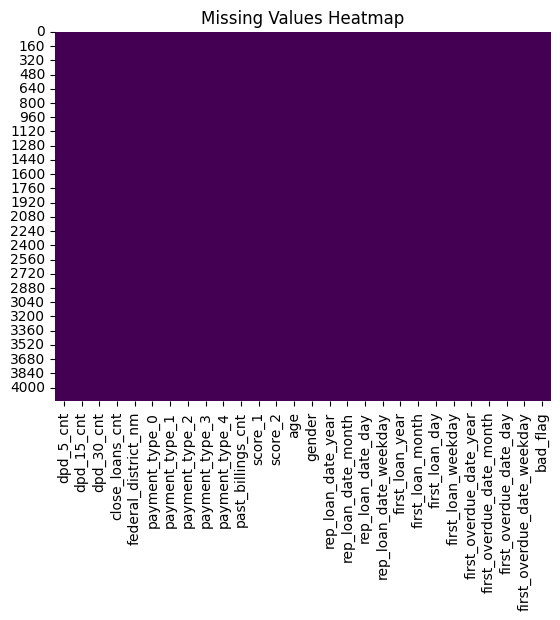

In [178]:
# Visualize missing values using a heatmap
sns.heatmap(df_capped.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

Good, the data ready to be used. Now let's check the class imbalance for future purpose.

Class Distribution:
 bad_flag
0    3739
1     417
Name: count, dtype: int64

Class Proportions:
 bad_flag
0    0.899663
1    0.100337
Name: count, dtype: float64


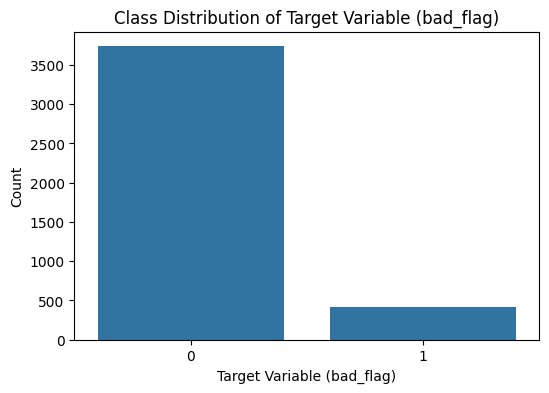

In [179]:
# Get the counts of each class in the target variable
class_counts = df_capped['bad_flag'].value_counts()

# Print the class counts
print("Class Distribution:\n", class_counts)

# Calculate and print the class proportions
class_proportions = class_counts / len(df_capped)
print("\nClass Proportions:\n", class_proportions)

# Visualize the class distribution using a bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='bad_flag', data=df_capped)
plt.title('Class Distribution of Target Variable (bad_flag)')
plt.xlabel('Target Variable (bad_flag)')
plt.ylabel('Count')
plt.show()

Look how imbalance the flags data, let's handle it later before training the data. <br>
Continue to explore it further like checking out the outliers (if available) within the visualization

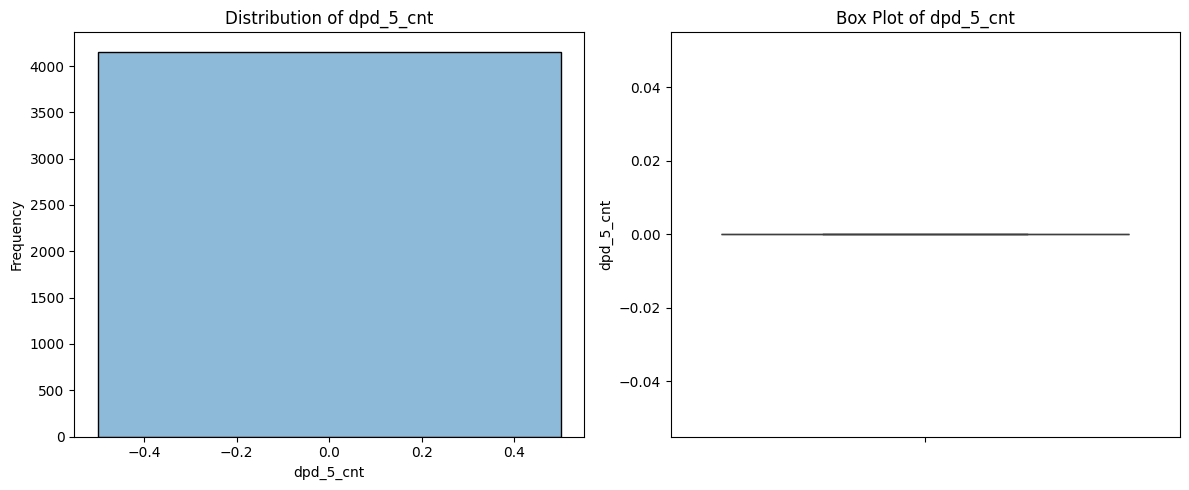

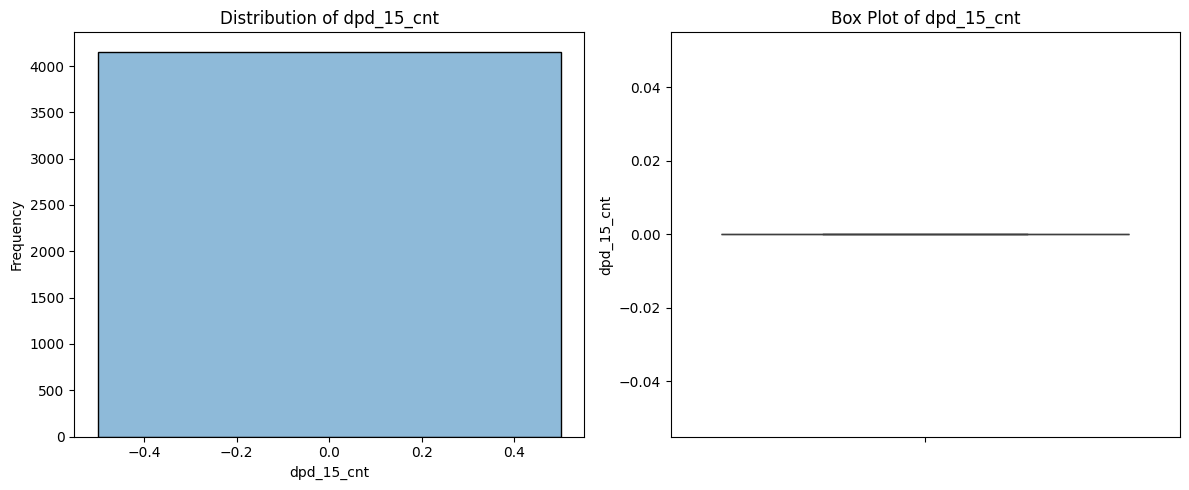

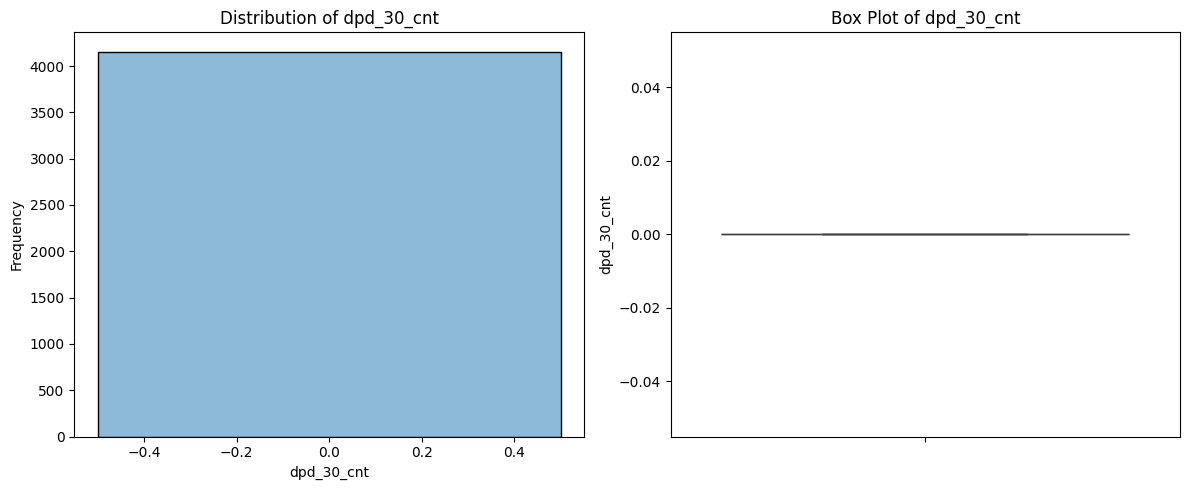

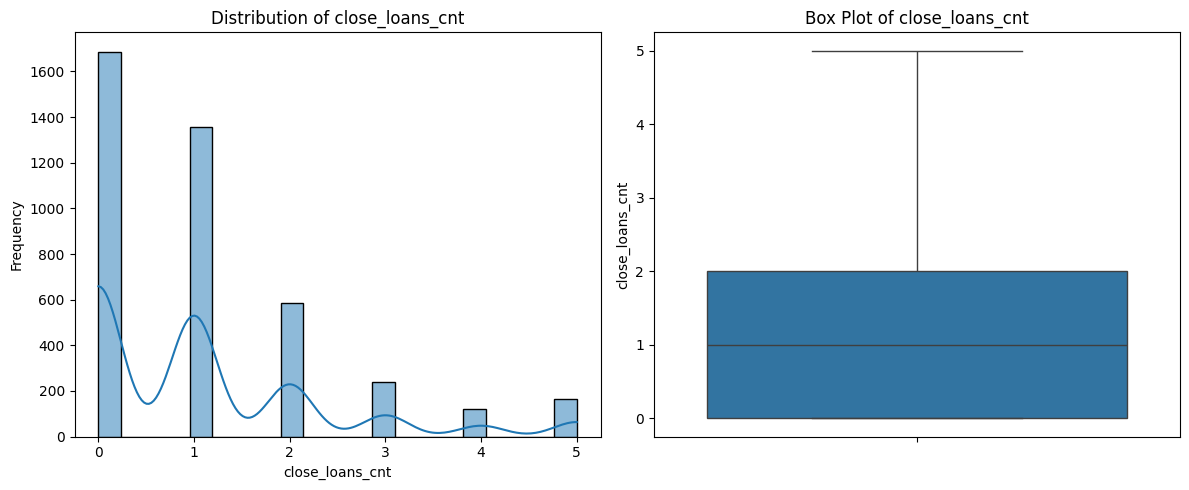

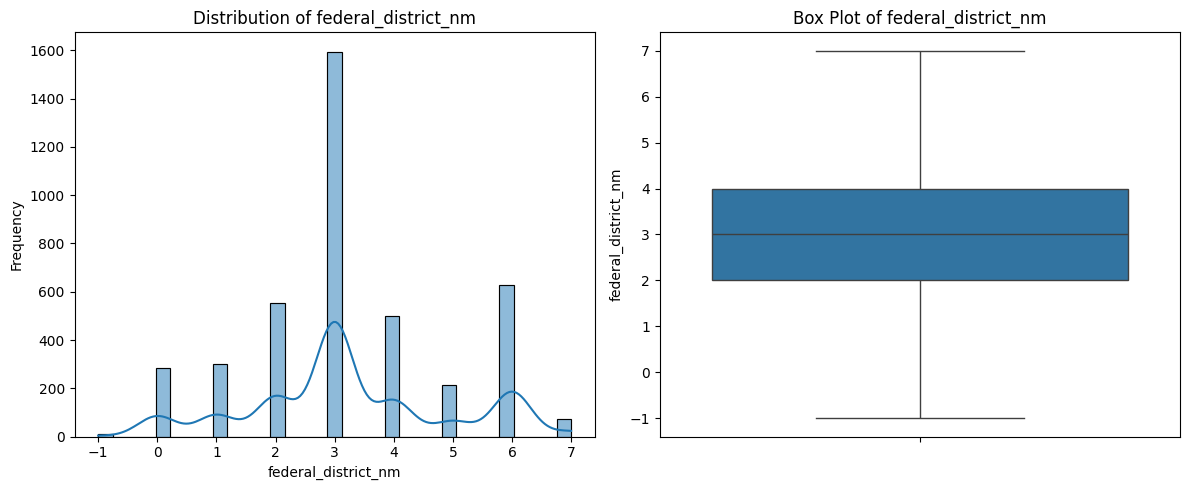

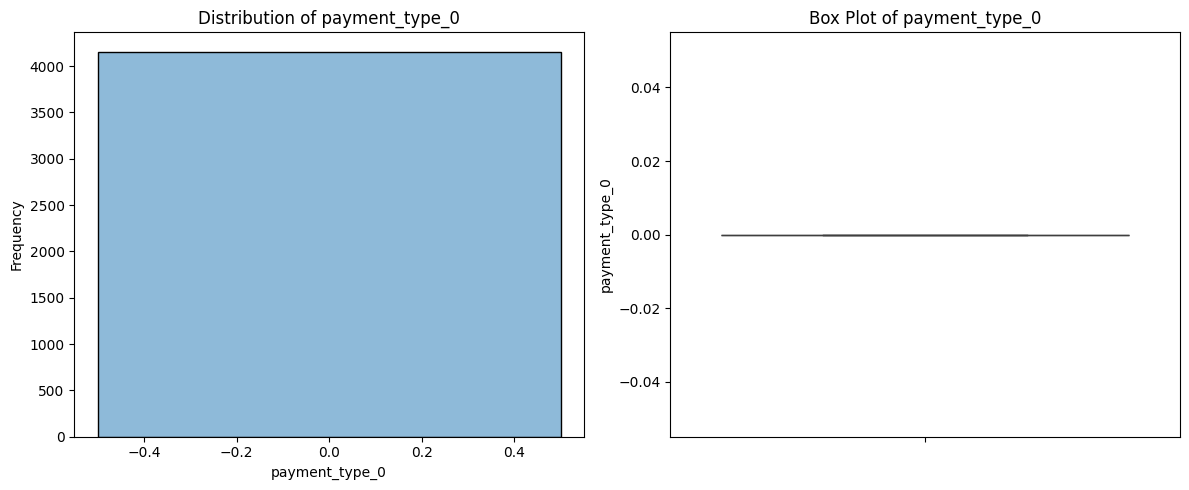

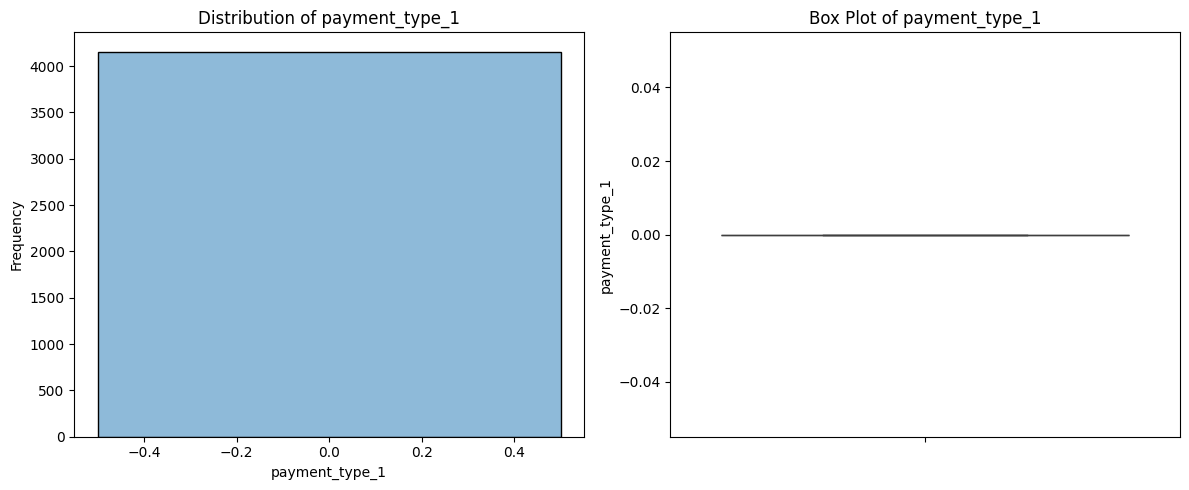

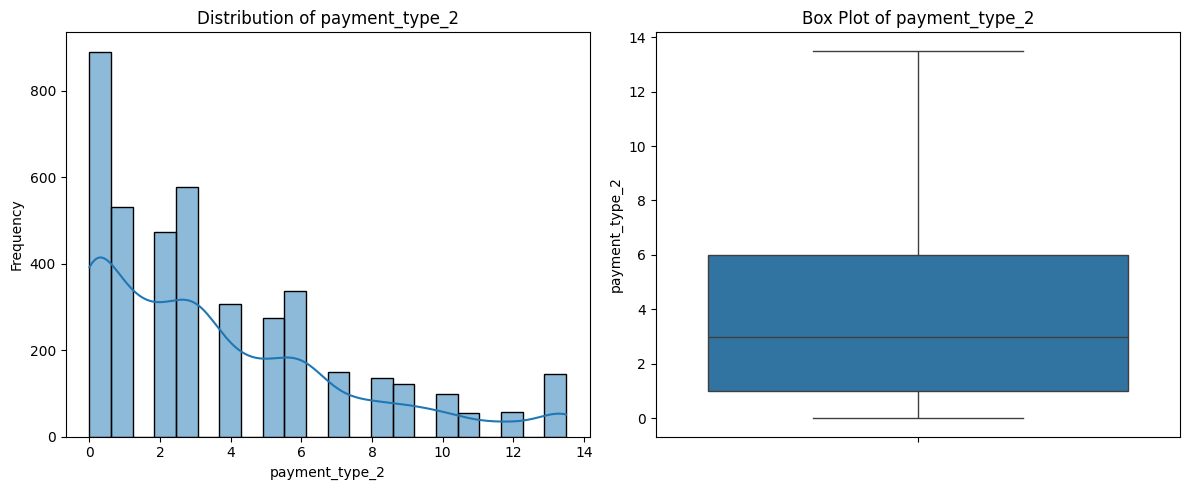

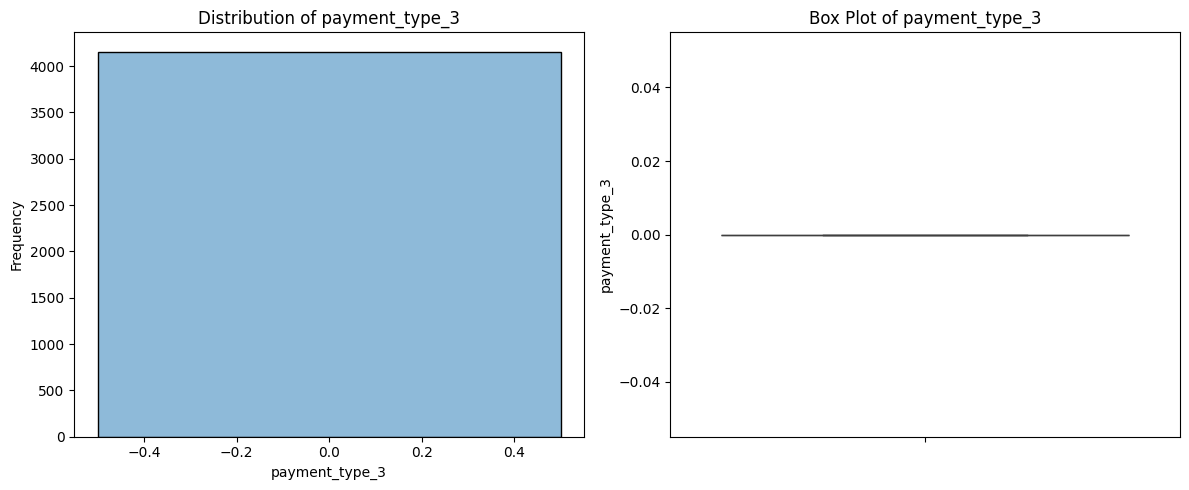

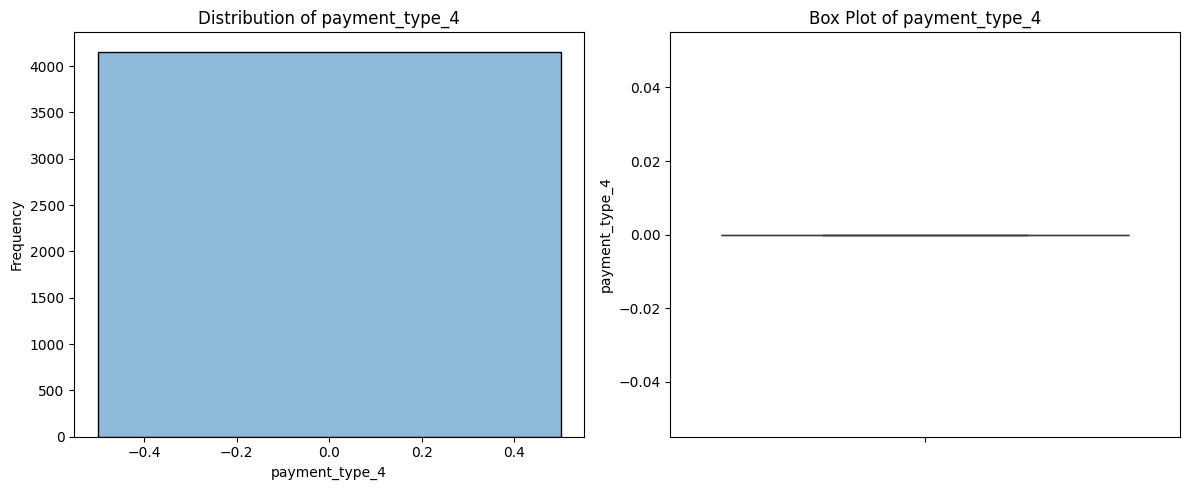

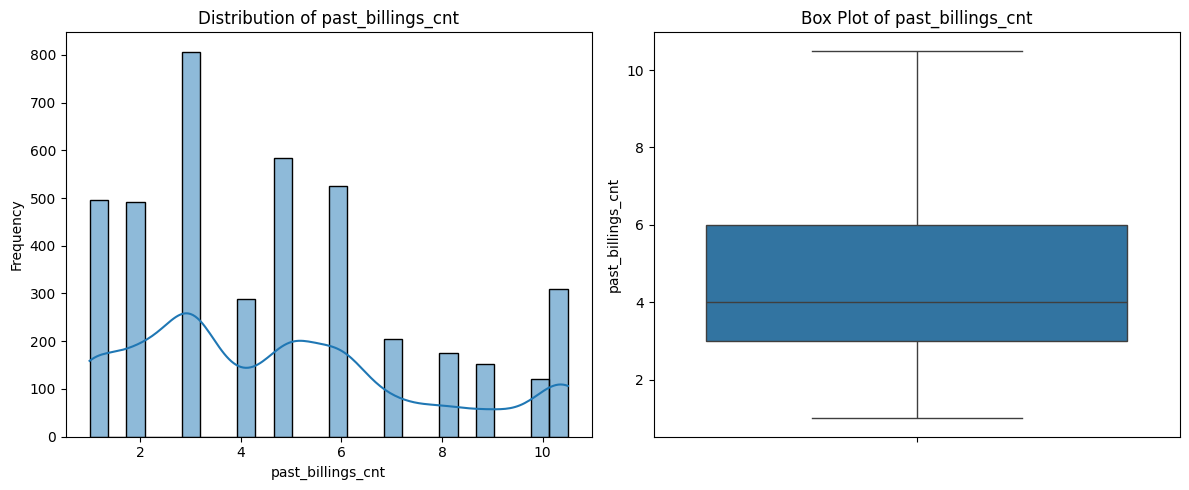

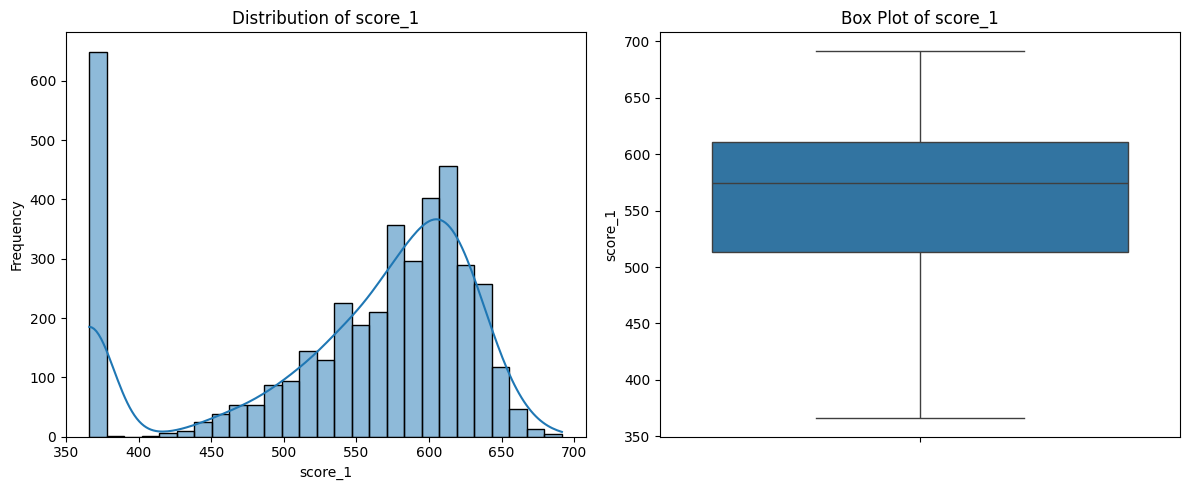

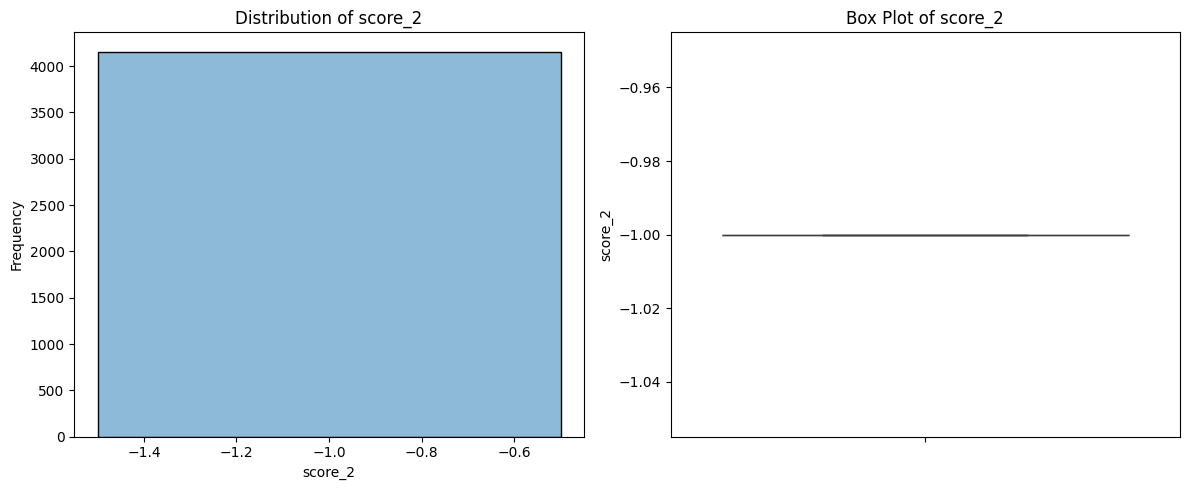

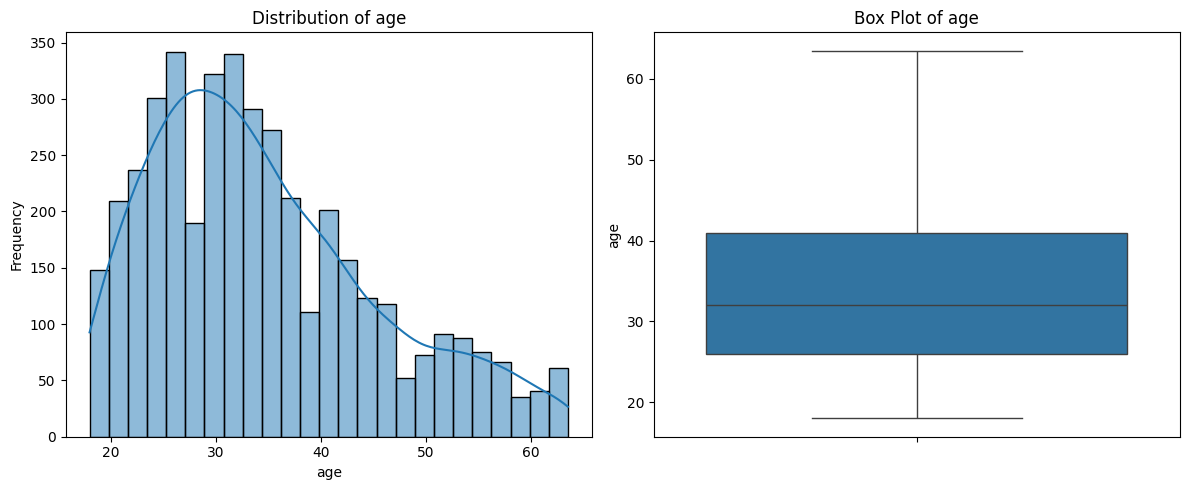

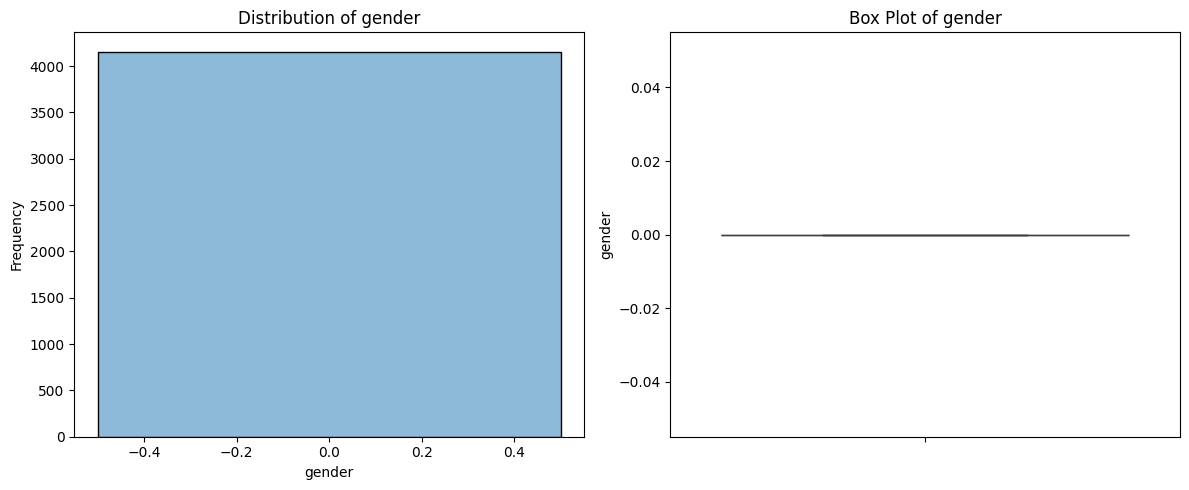

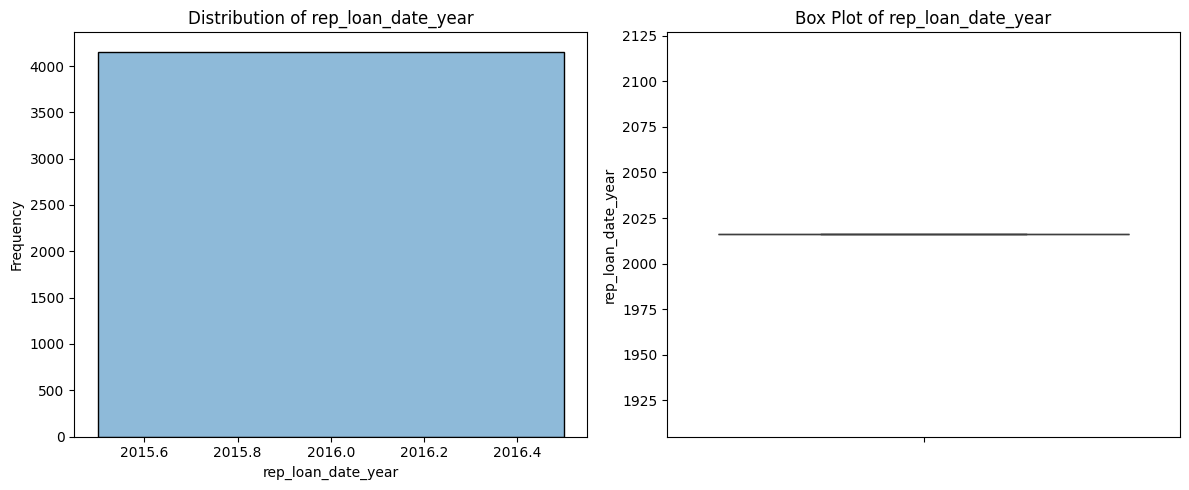

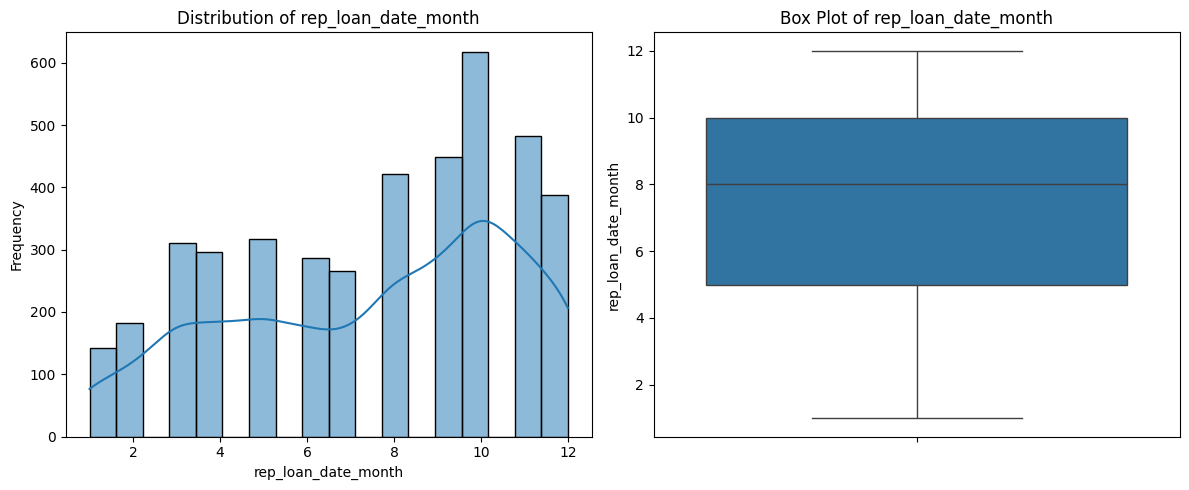

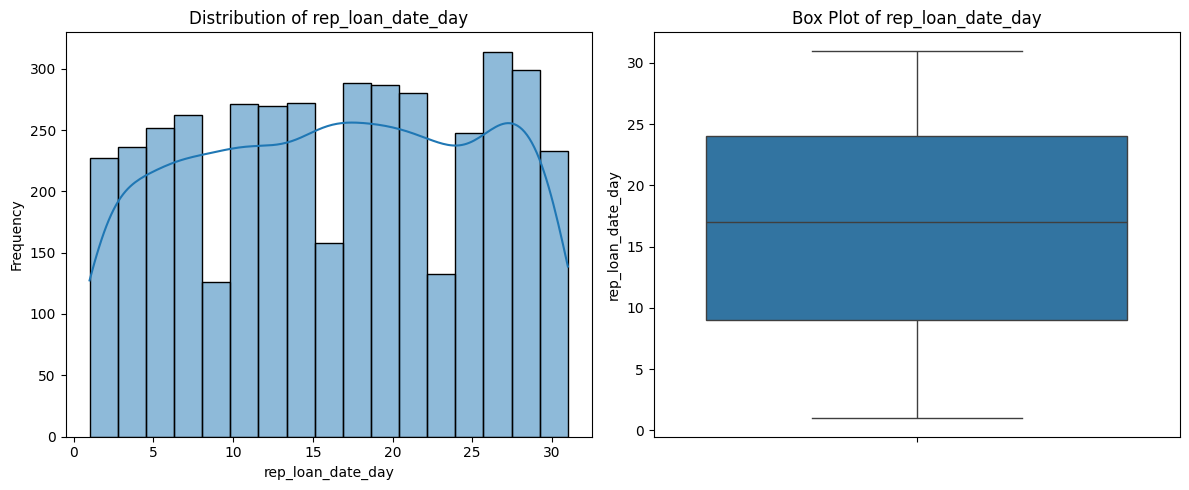

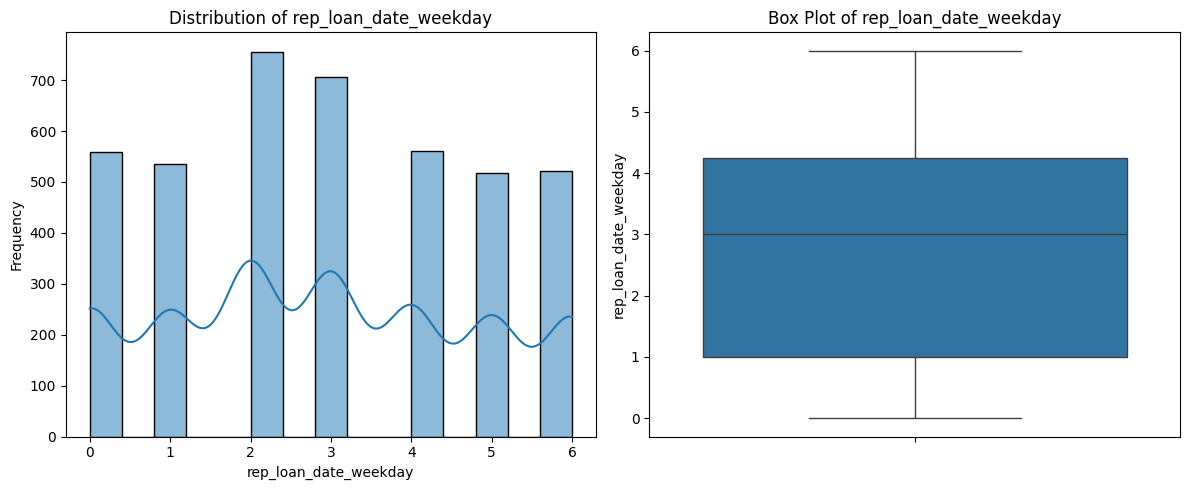

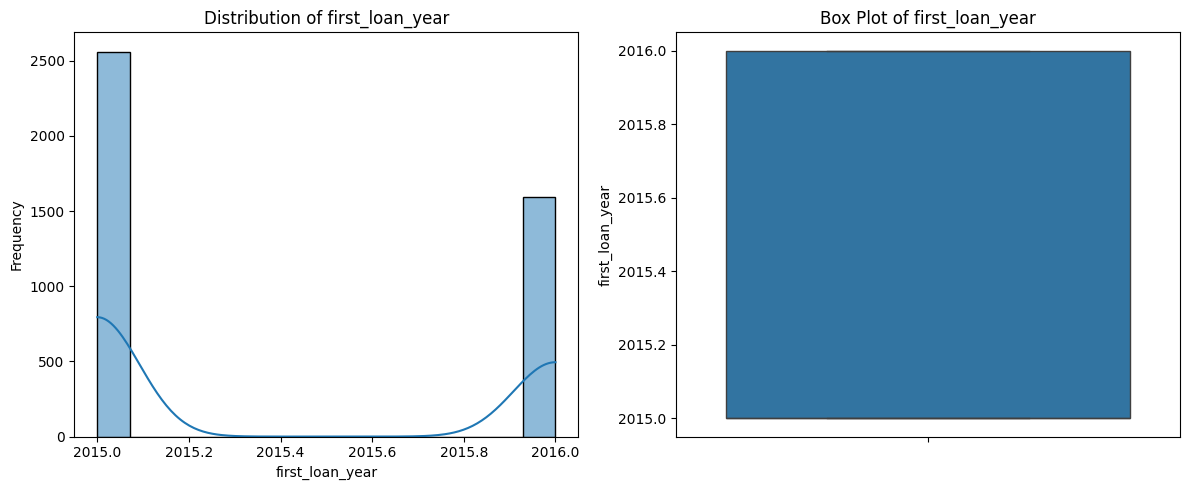

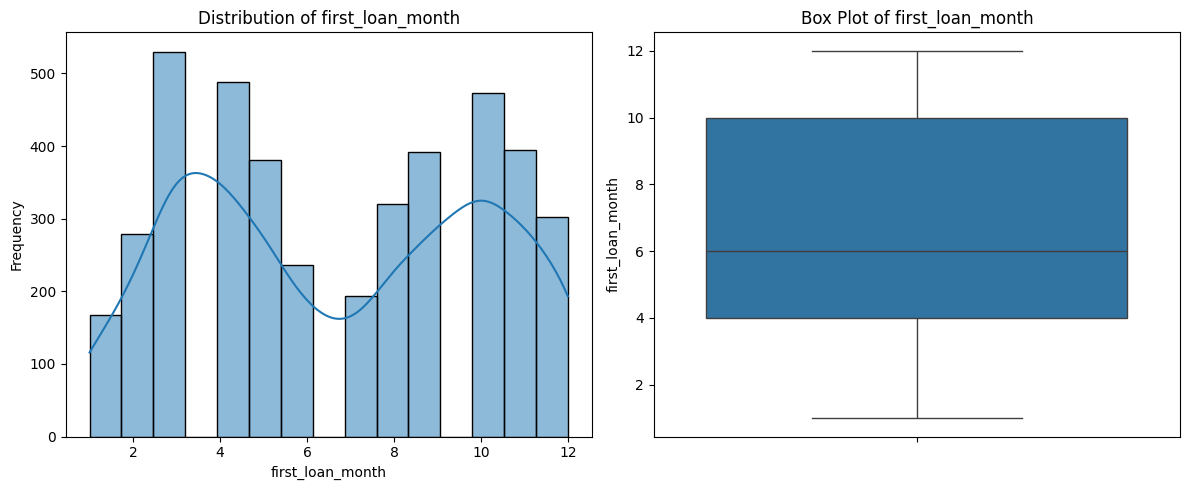

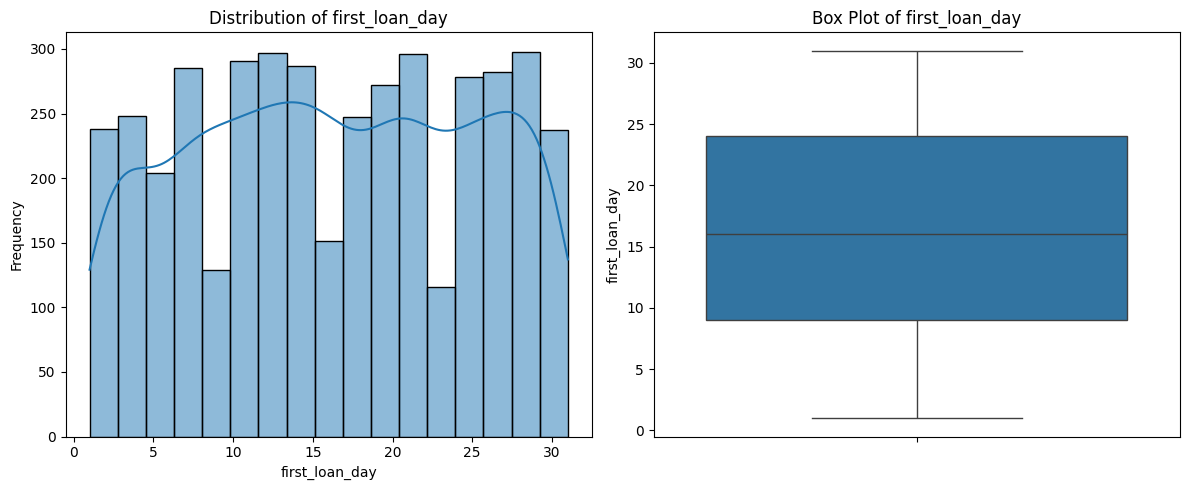

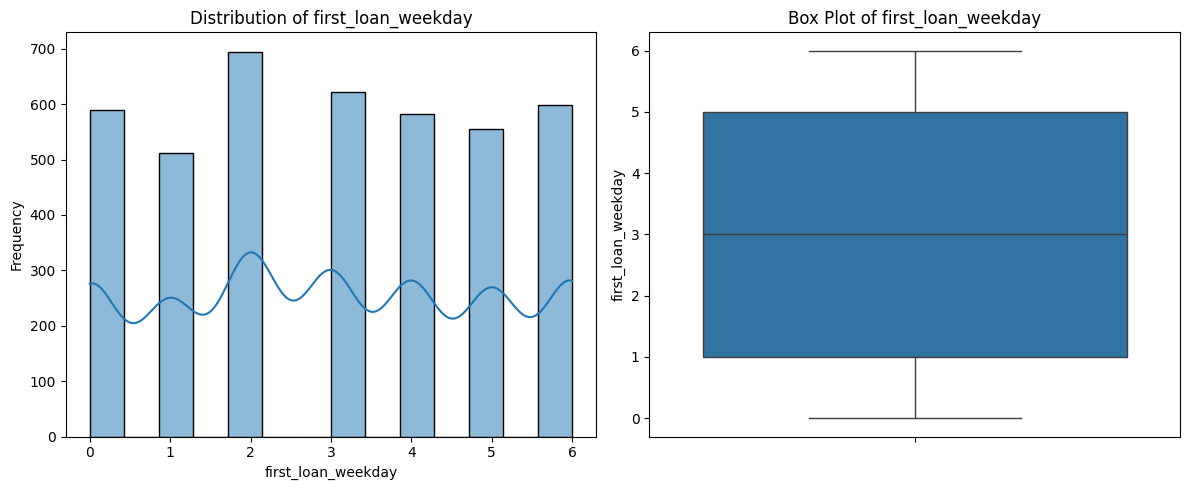

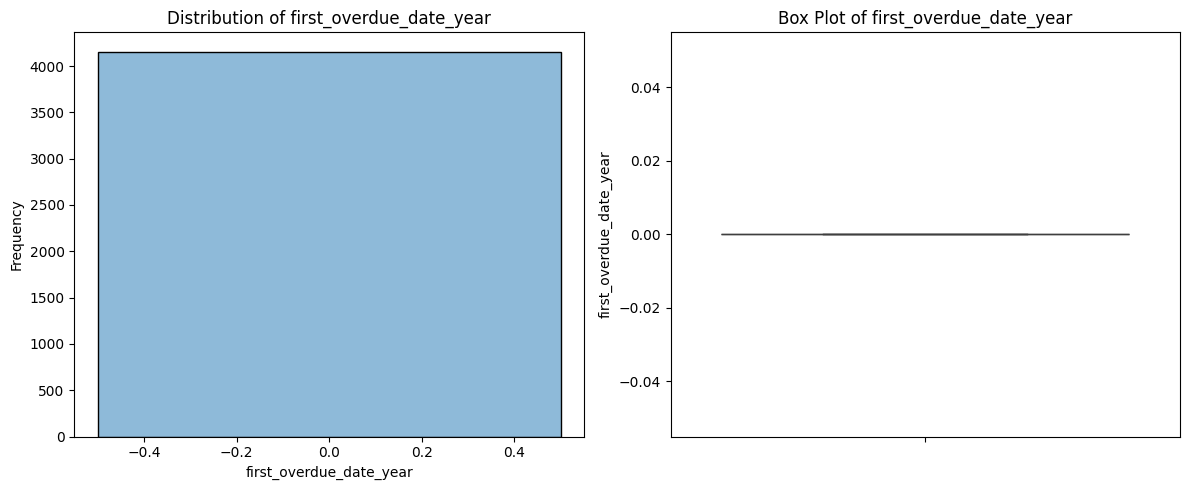

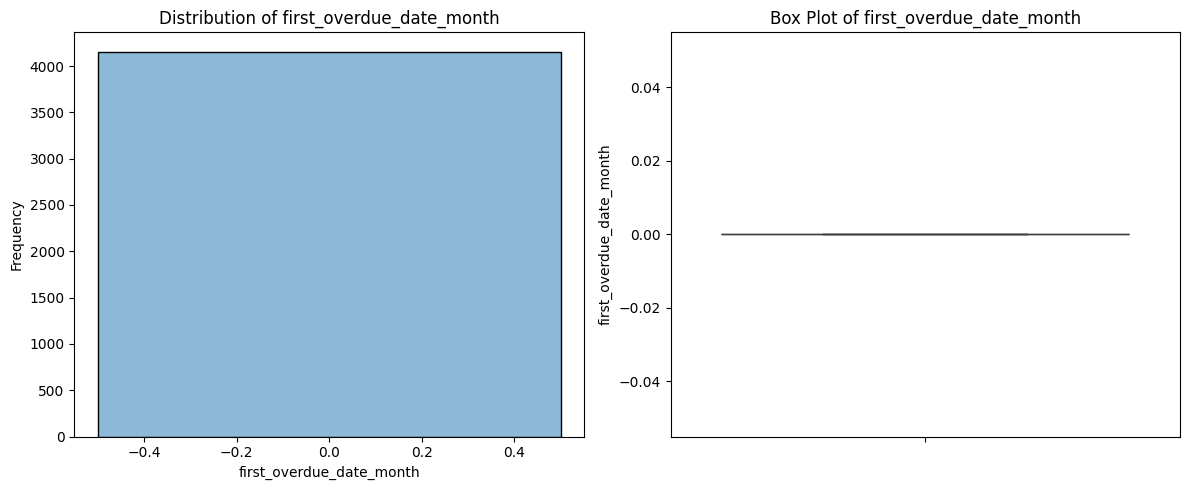

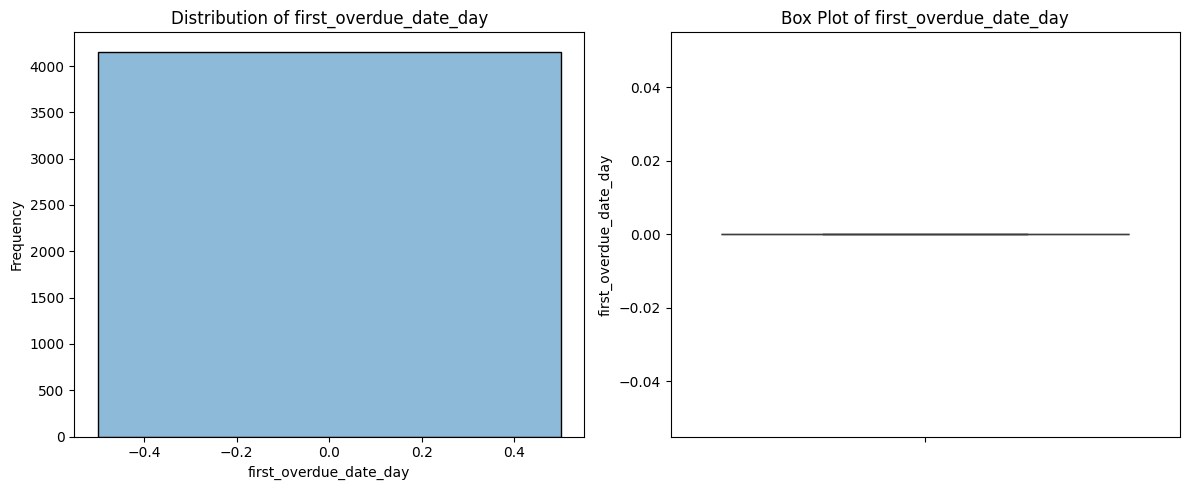

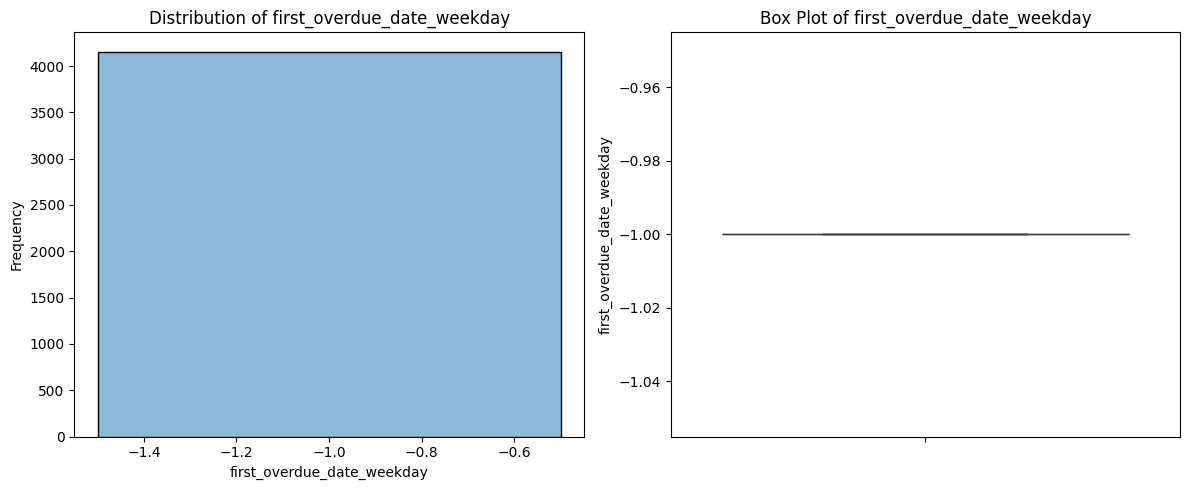

In [180]:
# Reassign numerical features
numerical_features = df_capped.select_dtypes(include=np.number).columns.tolist()
#numerical_features.remove('bad_flag')  # Remove the target variable if it's numerical, comment it otherwise.

# Loop through numerical features for univariate analysis
for feature in numerical_features:
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Subplot 1: Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_capped[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Subplot 2: Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_capped[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

# Use the code below only if any other than integer (like categorical) data exist in X features
# Loop through categorical features for univariate analysis
#categorical_features = df_capped.select_dtypes(include=['object']).columns.tolist()
# categorical_features.remove('bad_flag')  # Exclude target variable if it's categorical, comment it otherwise.

#for feature in categorical_features:
#    plt.figure(figsize=(8, 5))
#    sns.countplot(x=df_capped[feature])
#    plt.title(f'Distribution of {feature}')
#    plt.xlabel(feature)
#    plt.ylabel('Count')
#    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
#    plt.tight_layout()
#    plt.show()

The visual looks weird, is it because I removed the outliers that are not supposed to be removed within few of the features? Let's visualize the previous data instead.

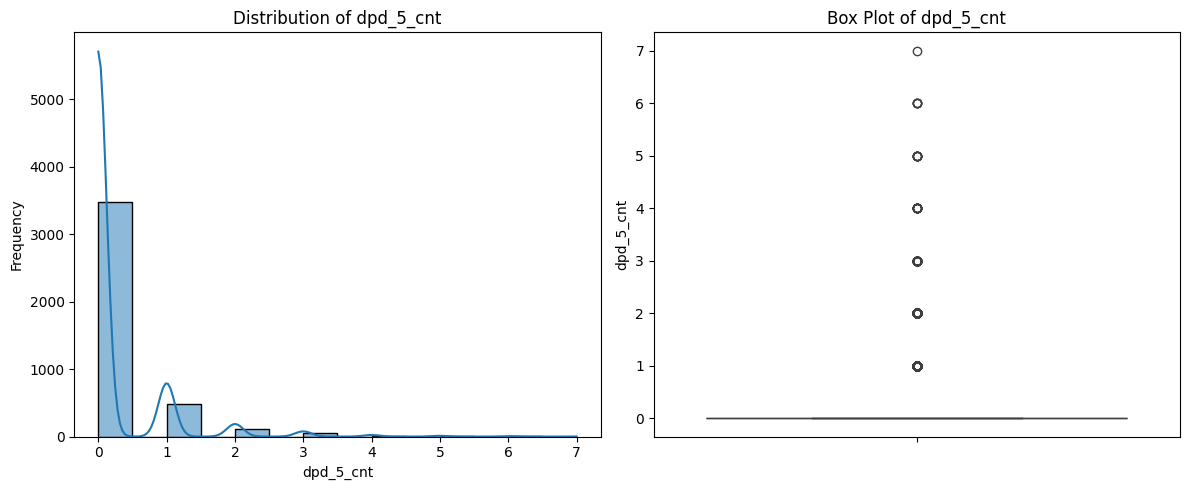

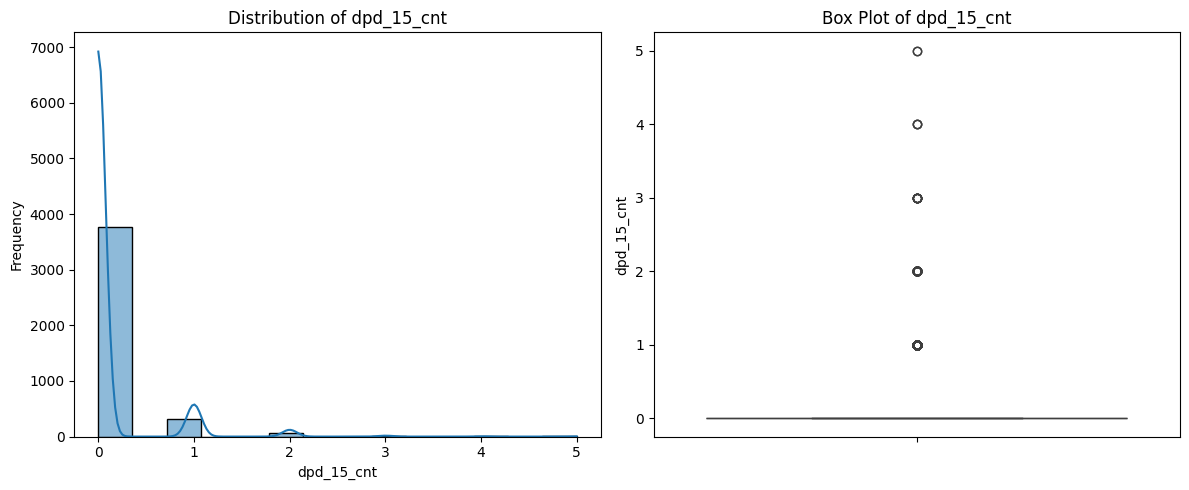

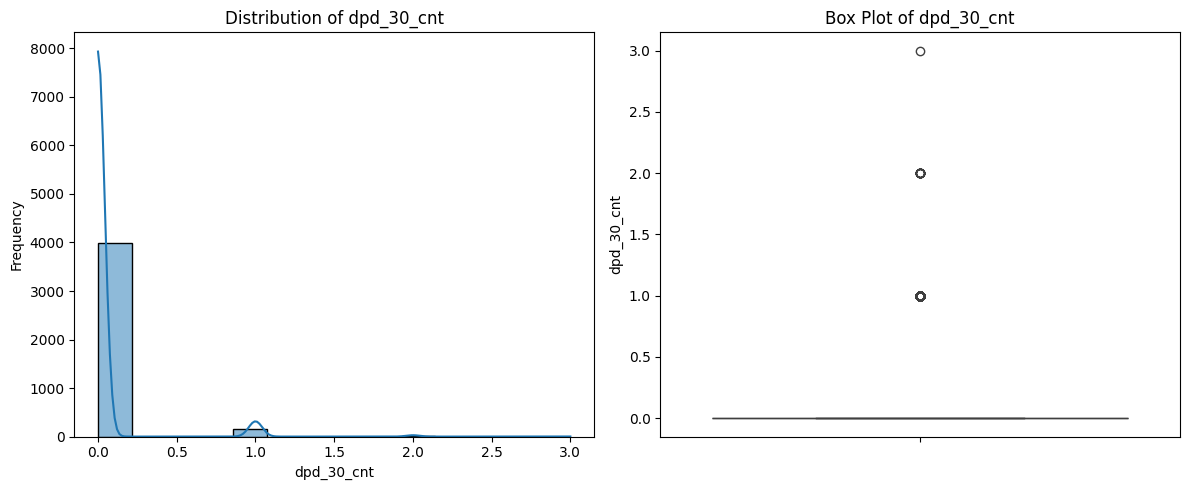

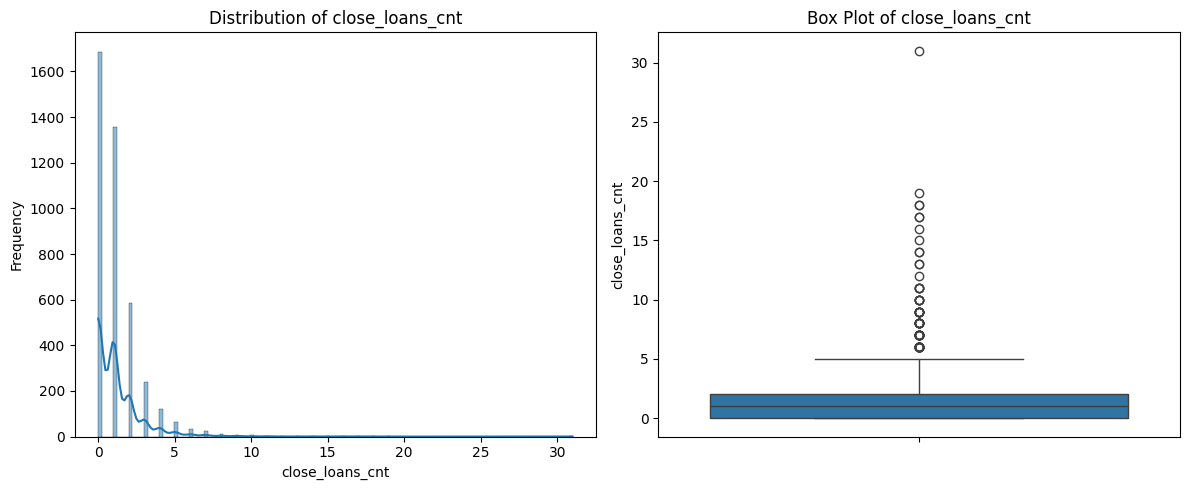

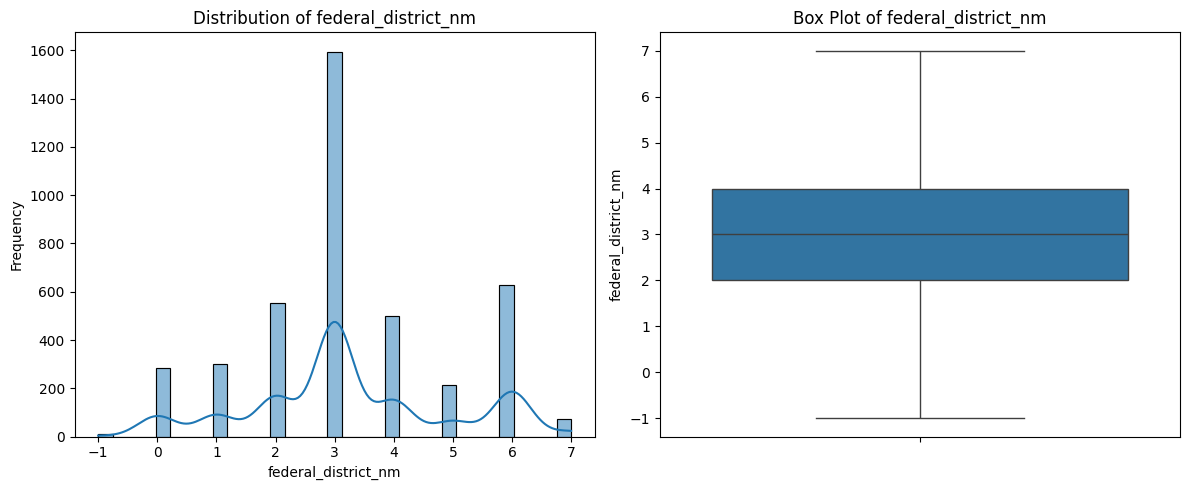

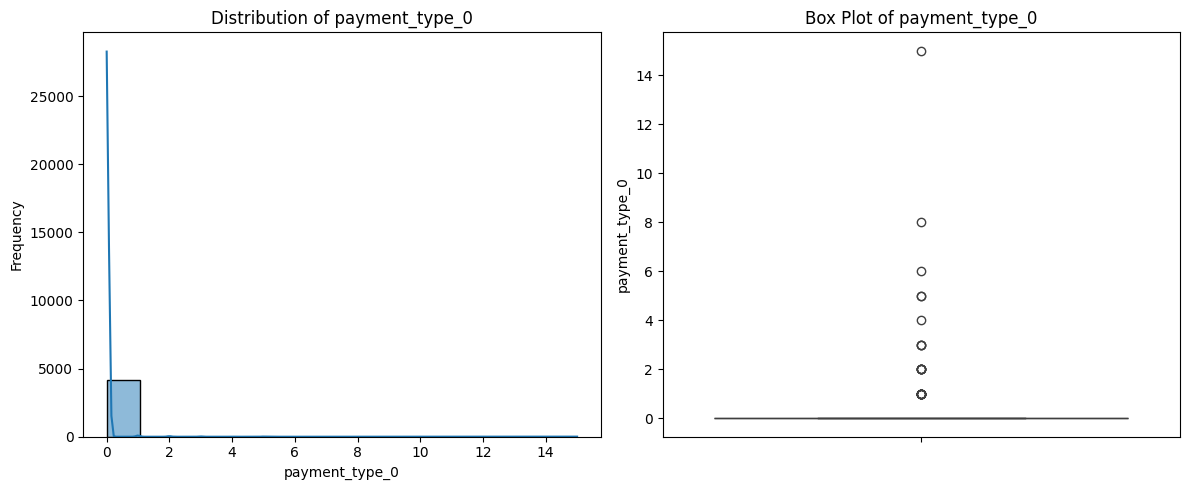

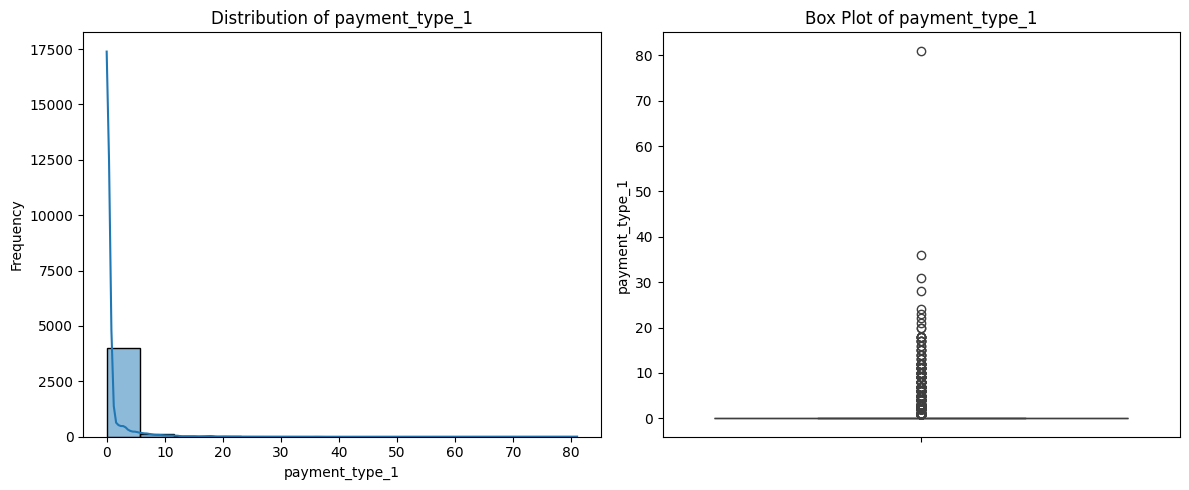

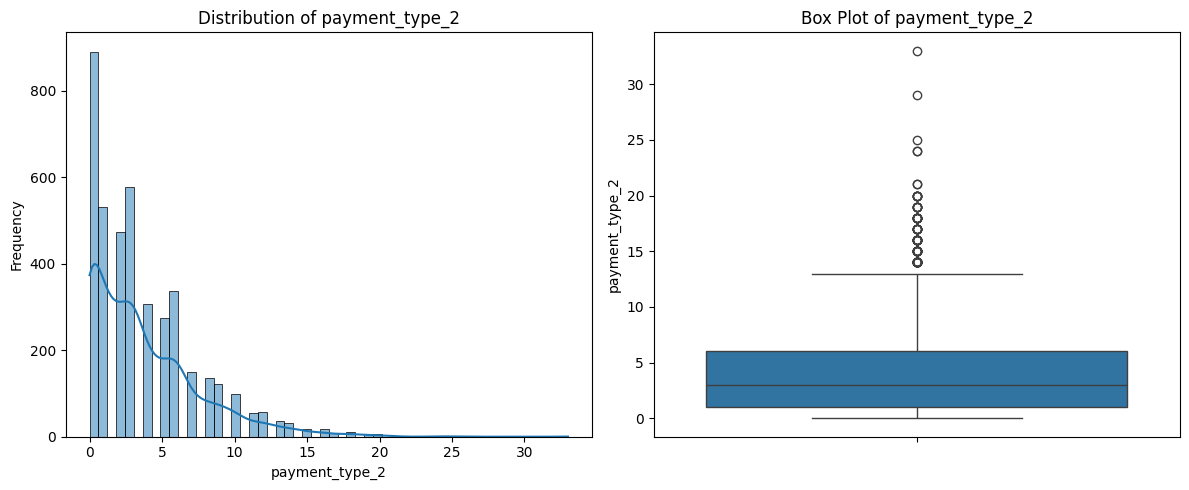

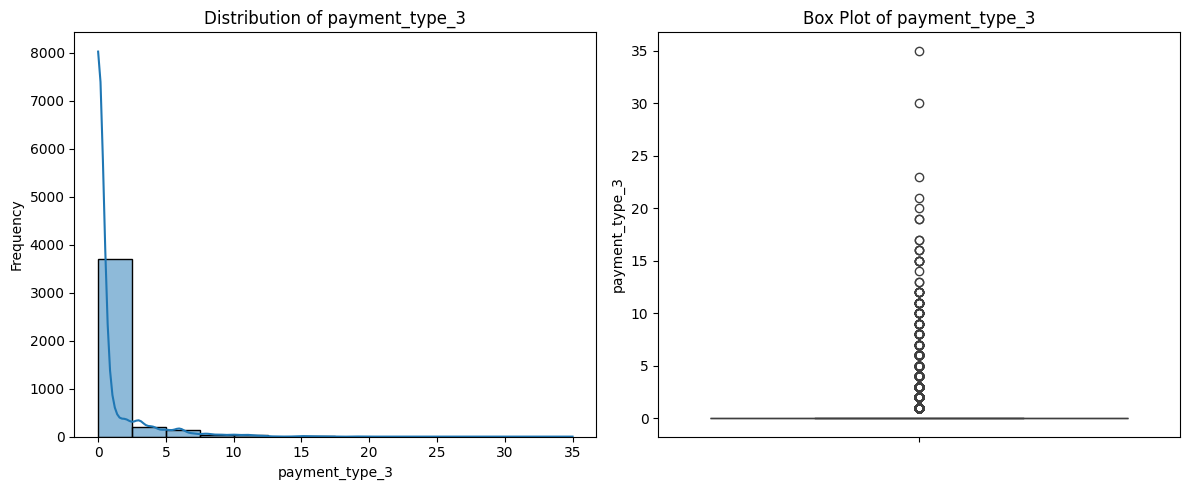

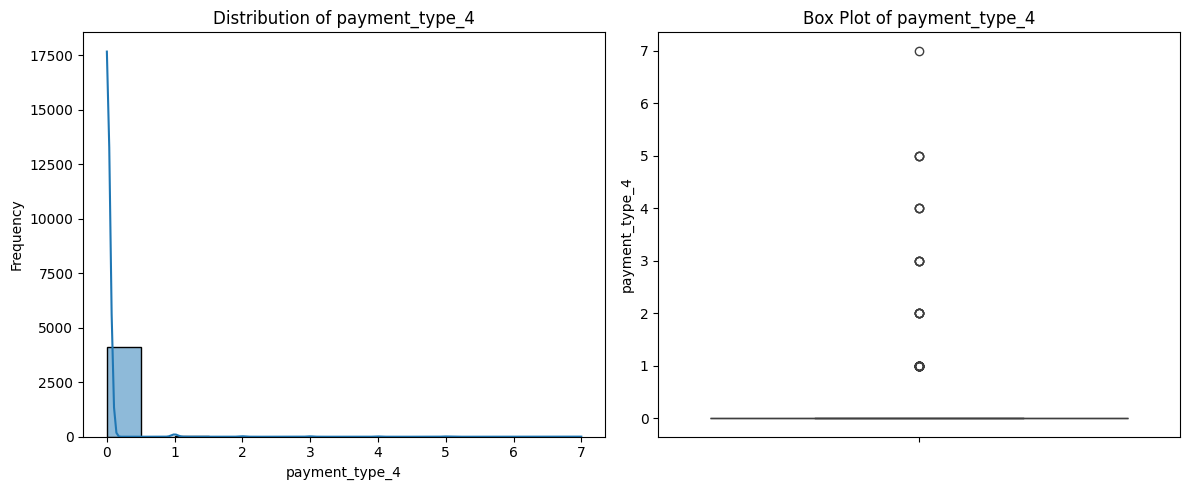

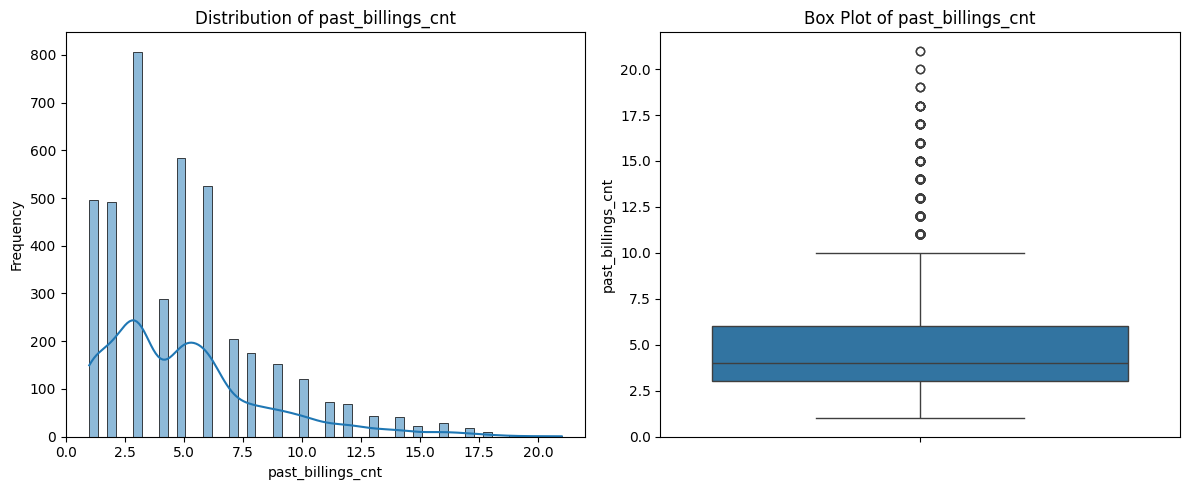

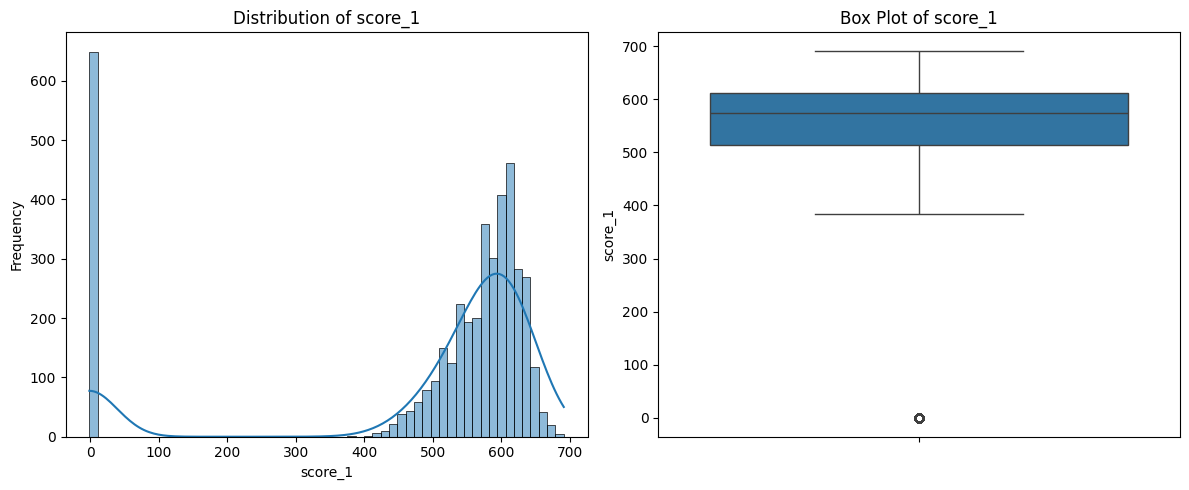

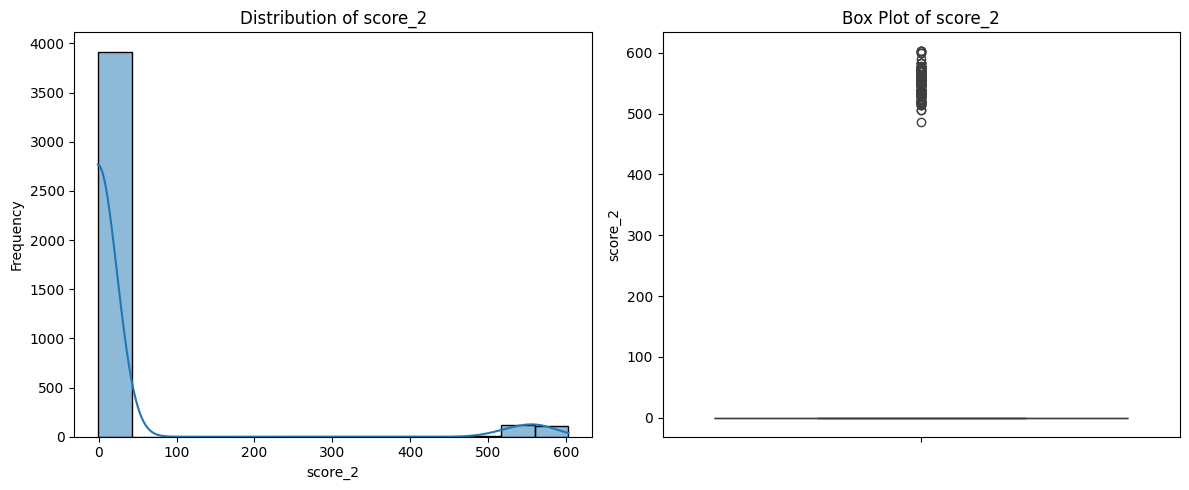

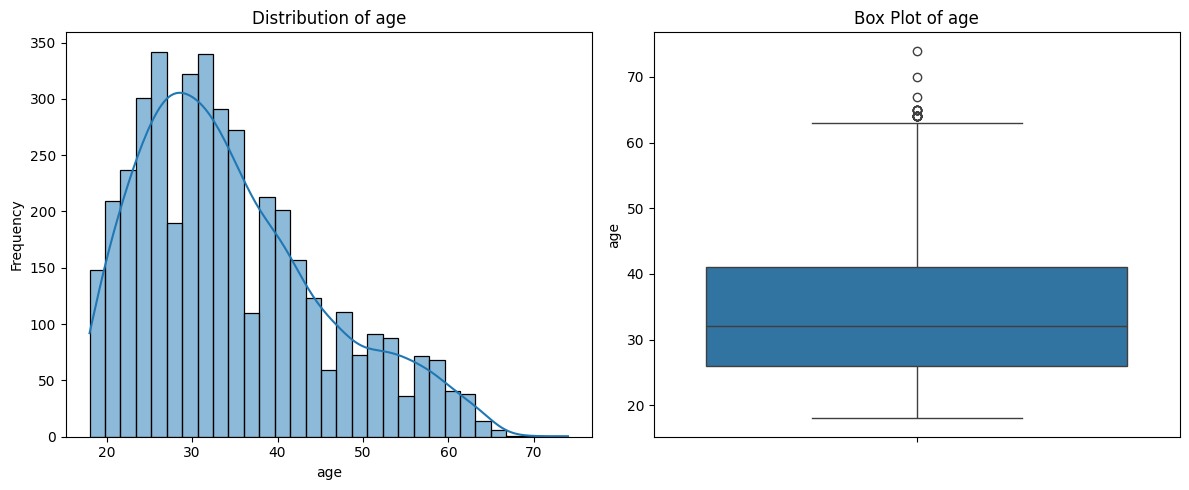

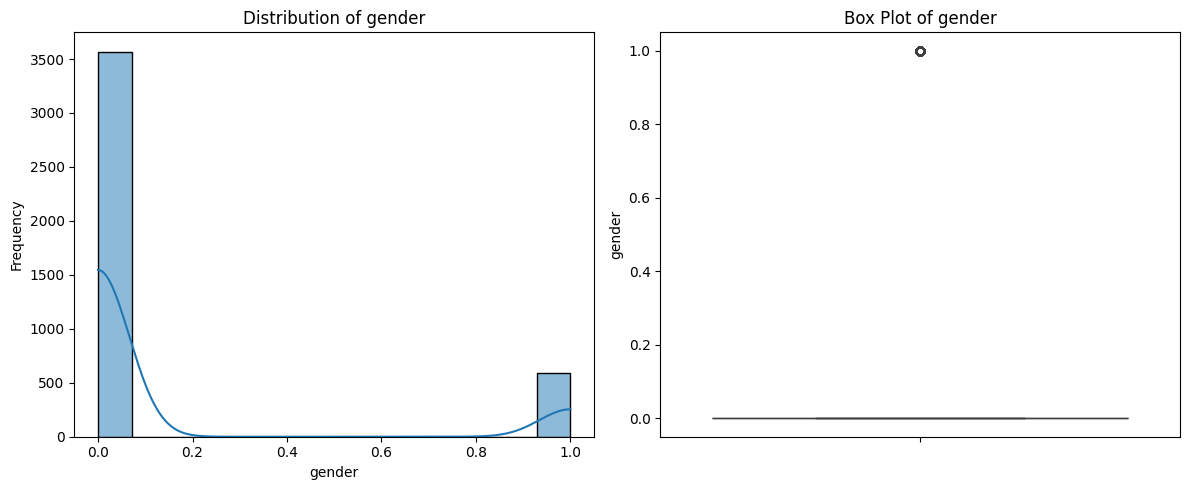

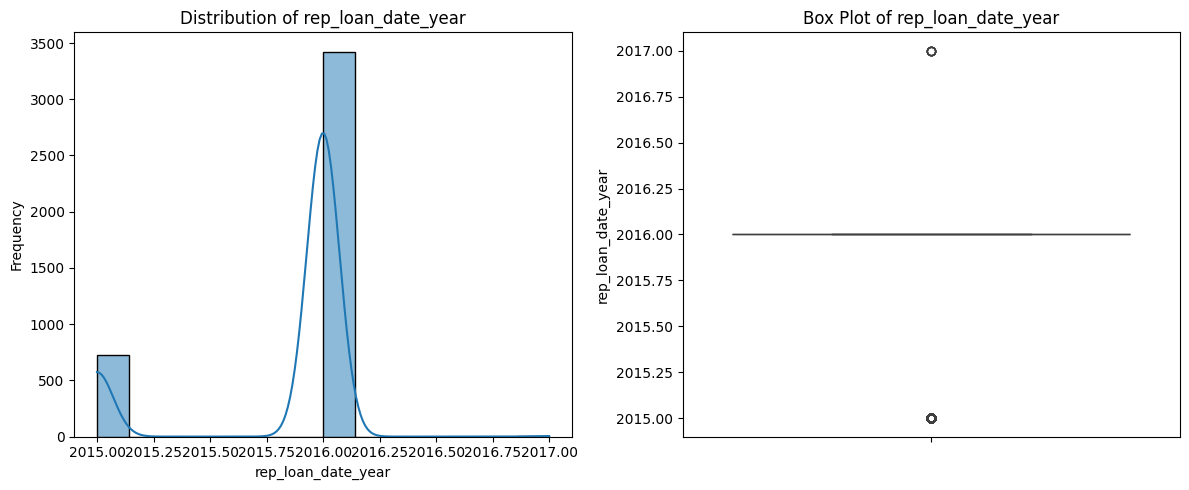

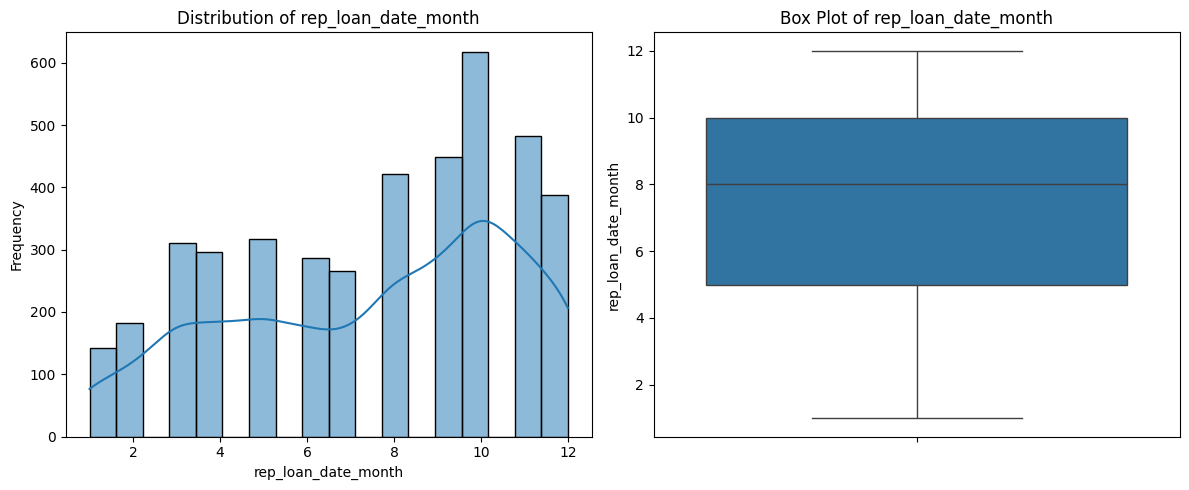

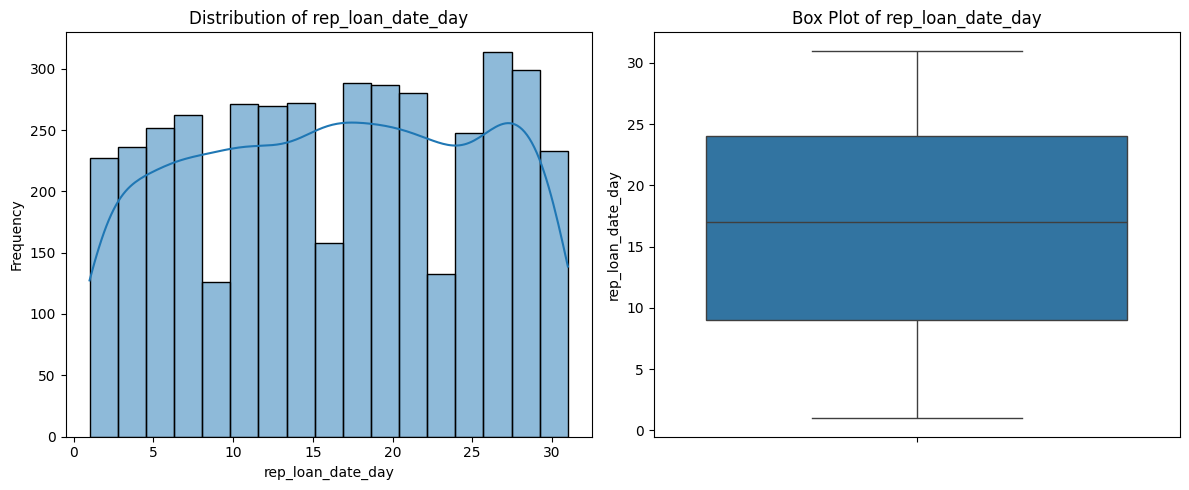

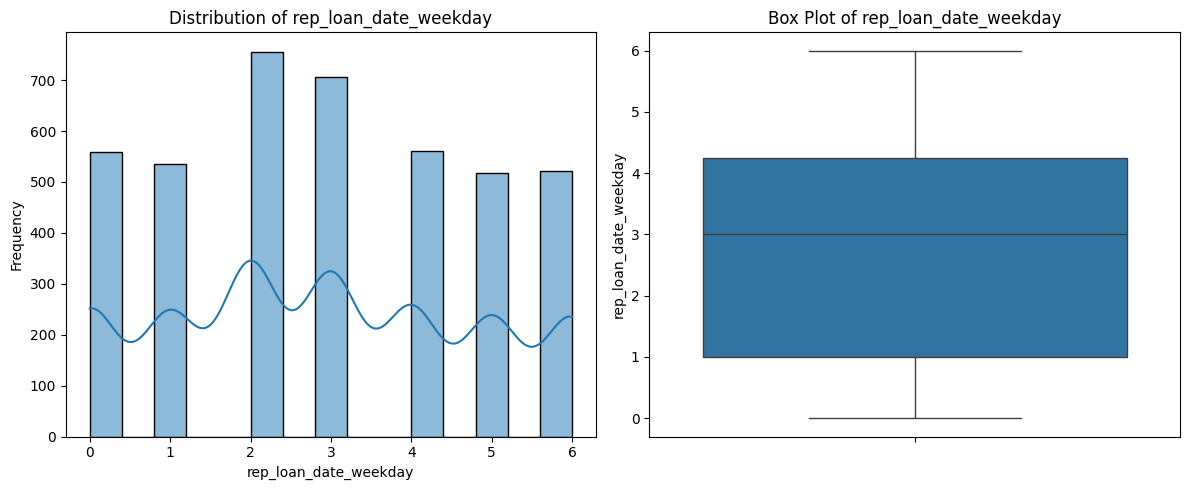

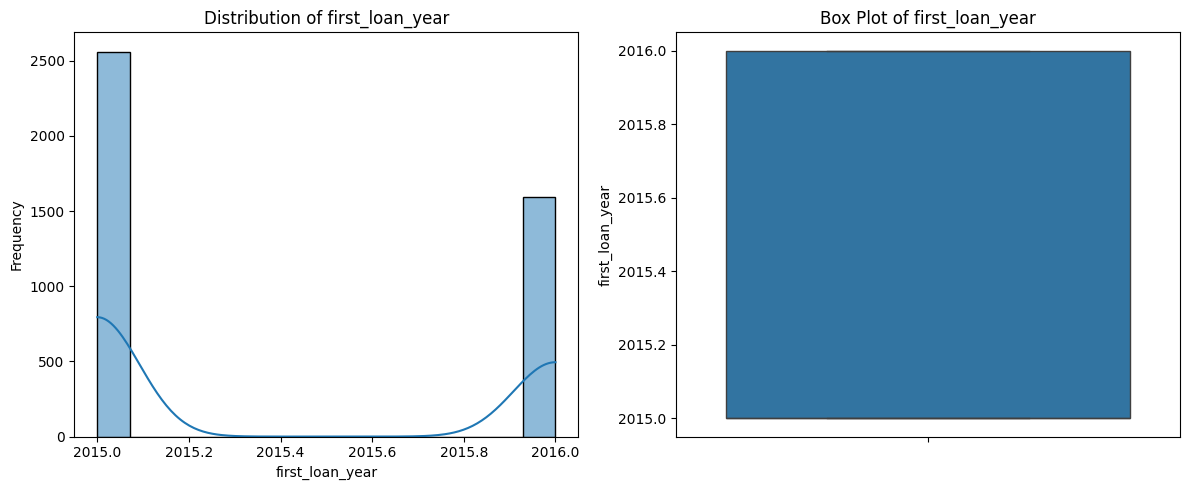

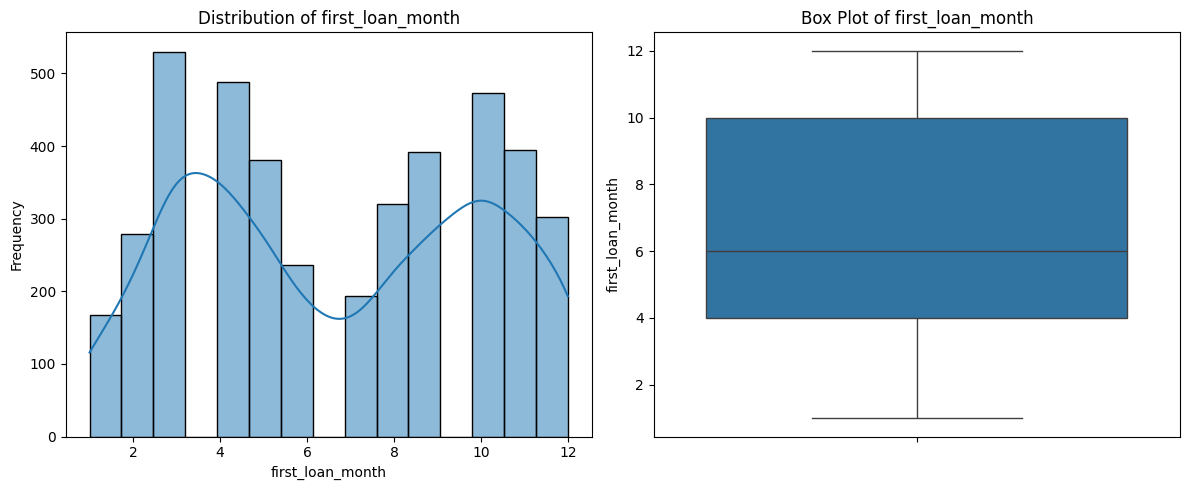

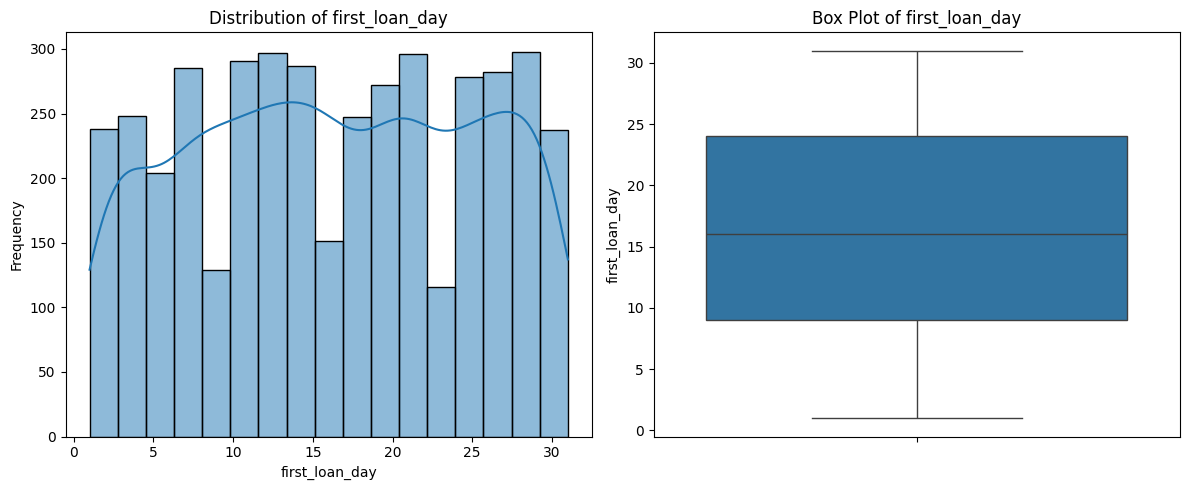

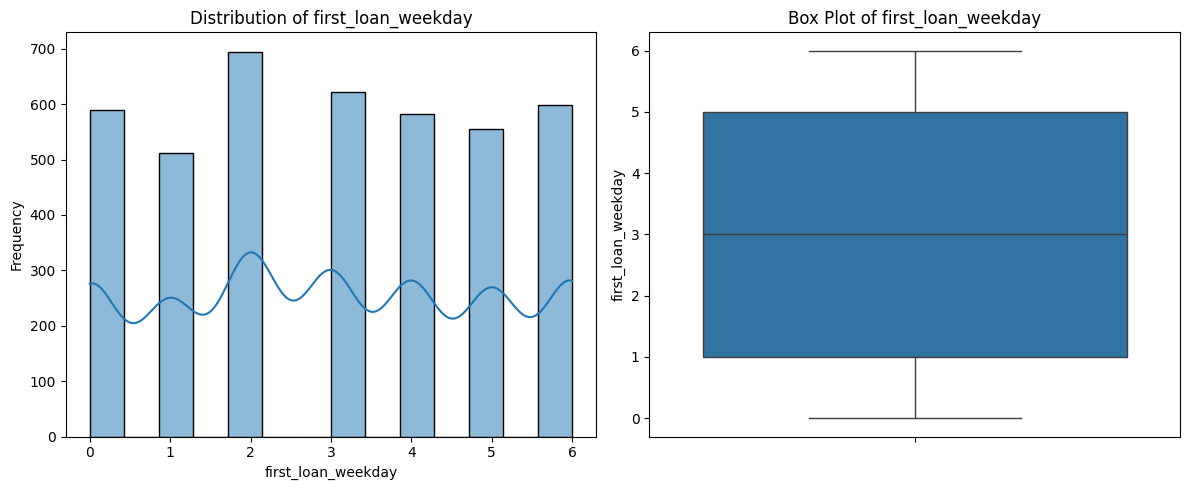

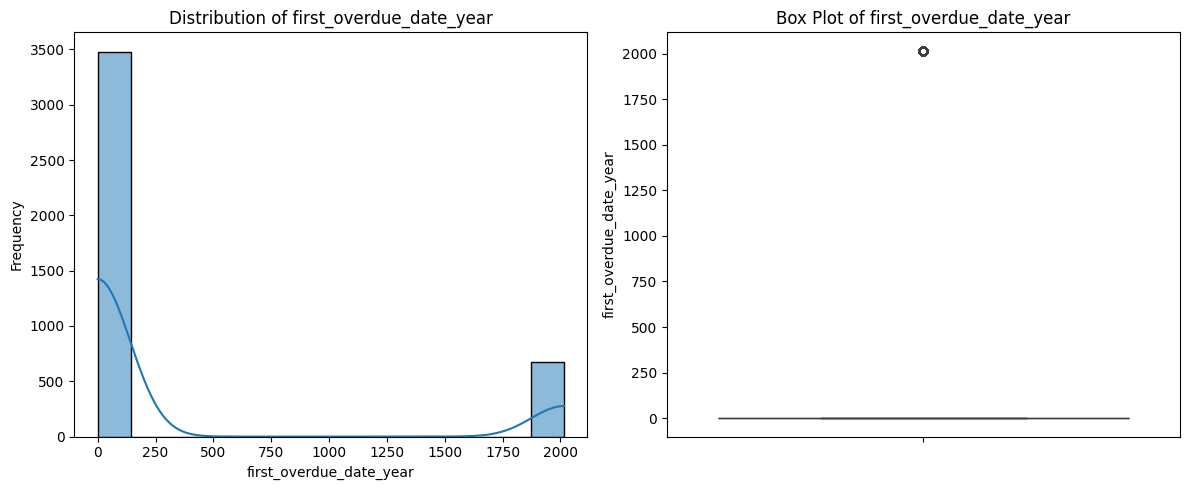

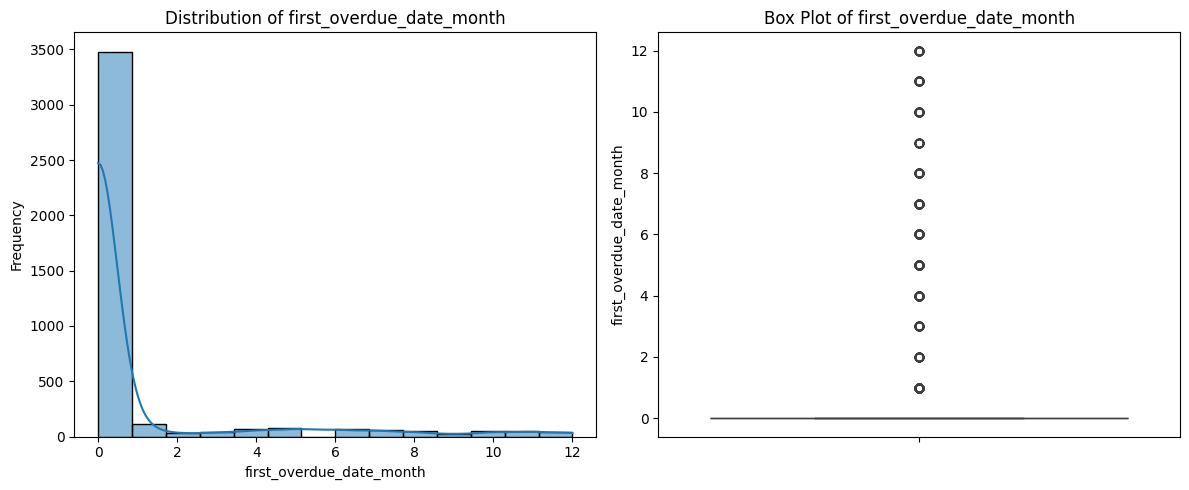

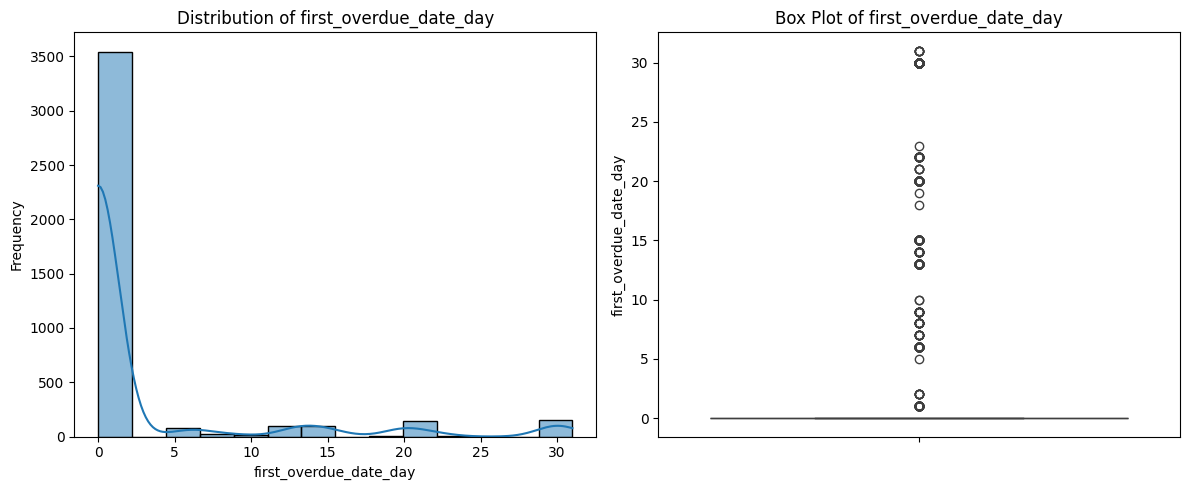

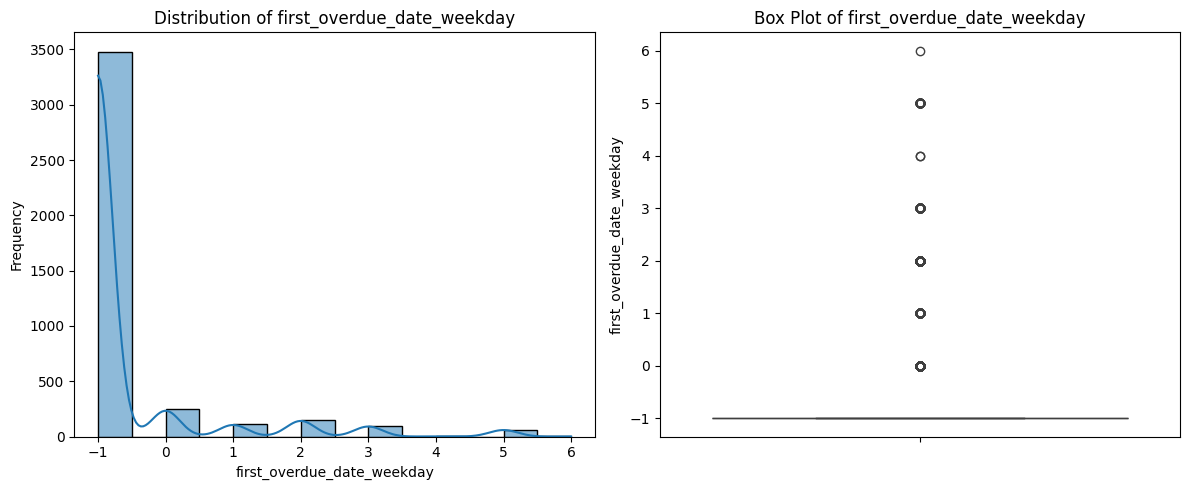

In [181]:
# Reassign numerical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
#numerical_features.remove('bad_flag')  # Remove the target variable if it's numerical, comment it otherwise.

# Loop through numerical features for univariate analysis
for feature in numerical_features:
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Subplot 1: Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Subplot 2: Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

It seems that there's no need to remove the outliers since every data point have valid context and might be useful.

dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  \
dpd_5_cnt                    1.000000    0.745059    0.462972   
dpd_15_cnt                   0.745059    1.000000    0.642316   
dpd_30_cnt                   0.462972    0.642316    1.000000   
close_loans_cnt              0.167287    0.155797    0.099661   
federal_district_nm         -0.005107    0.008599   -0.004056   
payment_type_0              -0.006853   -0.003858    0.001598   
payment_type_1               0.072731    0.053531    0.056300   
payment_type_2               0.190375    0.154675    0.095782   
payment_type_3               0.064552    0.075518    0.054900   
payment_type_4              -0.004558    0.003228    0.009977   
past_billings_cnt            0.231040    0.189933    0.142153   
score_1                     -0.062267   -0.024675   -0.038639   
score_2                     -0.027681   -0.016910   -0.008806   
age                         -0.081216   -0.045660   -0.056693   
gender                      -0.016842   -0.018400   -0.023405   
rep_loan_date_year           0.043866    0.048774    0.013145   
rep_loan_date_month         -0.020667   -0.001347    0.015075   
rep_loan_date_day           -0.005639    0.004545    0.012147   
rep_loan_date_weekday       -0.015562   -0.020024   -0.013533   
first_loan_year             -0.152151   -0.095342   -0.066517   
first_loan_month             0.013015    0.003606   -0.015996   
first_loan_day              -0.008383    0.012620    0.022028   
first_loan_weekday           0.037505    0.033644    0.022896   
first_overdue_date_year      0.826596    0.659965    0.454672   
first_overdue_date_month     0.733241    0.565383    0.384083   
first_overdue_date_day       0.706638    0.555825    0.410667   
first_overdue_date_weekday   0.719651    0.544960    0.385892   
bad_flag                     0.135659    0.121807    0.091802   

                            close_loans_cnt  federal_district_nm  \
dpd_5_cnt                          0.167287            -0.005107   
dpd_15_cnt                         0.155797             0.008599   
dpd_30_cnt                         0.099661            -0.004056   
close_loans_cnt                    1.000000            -0.024954   
federal_district_nm               -0.024954             1.000000   
payment_type_0                     0.066895            -0.018722   
payment_type_1                     0.218480            -0.011638   
payment_type_2                     0.538758            -0.037986   
payment_type_3                     0.272590             0.004340   
payment_type_4                     0.049669            -0.028548   
past_billings_cnt                  0.719299            -0.040914   
score_1                            0.033475             0.022655   
score_2                           -0.078400            -0.004300   
age                               -0.030849            -0.014108   
gender                            -0.030354             0.017648   
rep_loan_date_year                 0.167650             0.044965   
rep_loan_date_month                0.087721             0.016739   
rep_loan_date_day                  0.012292            -0.031313   
rep_loan_date_weekday             -0.013688            -0.012072   
first_loan_year                   -0.283642             0.043879   
first_loan_month                  -0.053797             0.064500   
first_loan_day                     0.033981            -0.035705   
first_loan_weekday                 0.009961             0.017440   
first_overdue_date_year            0.150998            -0.032117   
first_overdue_date_month           0.104661            -0.039197   
first_overdue_date_day             0.127801            -0.030777   
first_overdue_date_weekday         0.134545            -0.031111   
bad_flag                          -0.071652            -0.003734   

                            payment_type_0  payment_type_1  payment_type_2  \
dpd_5_cnt                        -0.006853        0.072731        0.190375   
dpd_15_cnt   

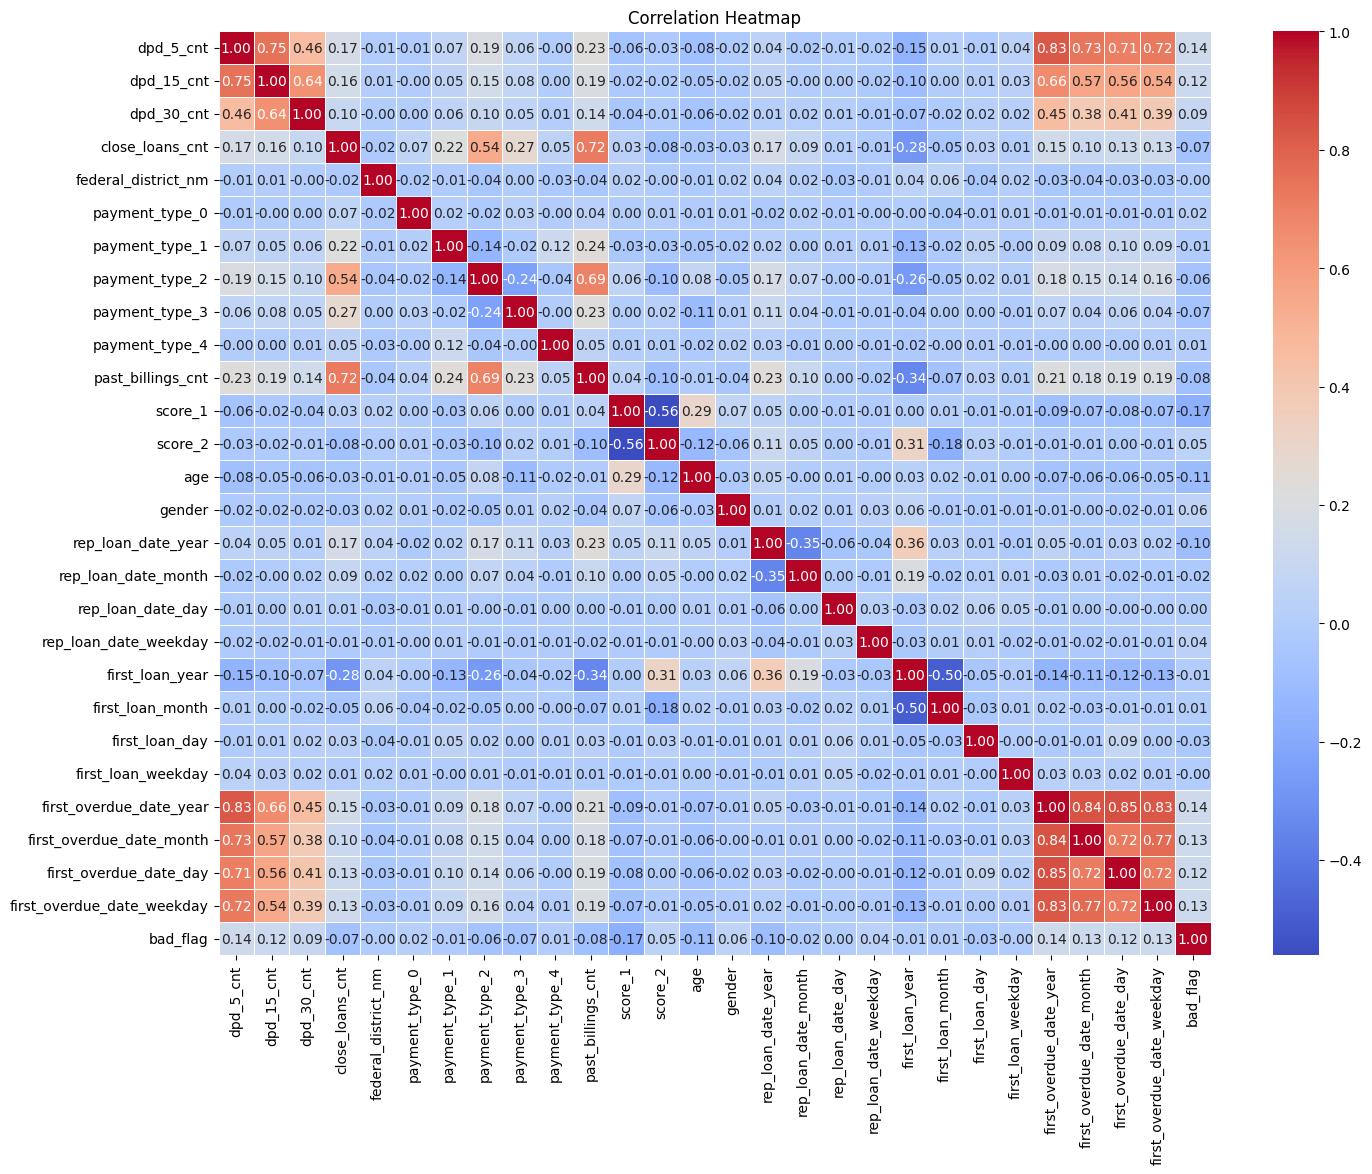

In [182]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
display(correlation_matrix)

# Create the heatmap
plt.figure(figsize=(16, 12))  # Adjust figsize for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [188]:
# Apply PCA to address collinearity within the features

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Apply PCA to 'dpd' features ---
dpd_features = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']

# Scale the 'dpd' features
scaler_dpd = StandardScaler()
scaled_dpd_features = scaler_dpd.fit_transform(df[dpd_features])

# Apply PCA to 'dpd' features
pca_dpd = PCA(n_components=2)  # Select 2 principal components for 'dpd'
dpd_pca = pca_dpd.fit_transform(scaled_dpd_features)

# Create new columns for 'dpd' principal components
df['dpd_pca_1'] = dpd_pca[:, 0]
df['dpd_pca_2'] = dpd_pca[:, 1]

# --- Apply PCA to 'overdue_date' features ---
overdue_features = ['first_overdue_date_year', 'first_overdue_date_month',
                    'first_overdue_date_day', 'first_overdue_date_weekday']

# Scale the 'overdue_date' features
scaler_overdue = StandardScaler()
scaled_overdue_features = scaler_overdue.fit_transform(df[overdue_features])

# Apply PCA to 'overdue_date' features
pca_overdue = PCA(n_components=3)  # Select 3 principal components for 'overdue_date'
overdue_pca = pca_overdue.fit_transform(scaled_overdue_features)

# Create new columns for 'overdue_date' principal components
df['overdue_pca_1'] = overdue_pca[:, 0]
df['overdue_pca_2'] = overdue_pca[:, 1]
df['overdue_pca_3'] = overdue_pca[:, 2]

# --- Remove original features and reorder columns ---
# Remove the original 'dpd' and 'overdue_date' features
df_new = df.drop(dpd_features + overdue_features, axis=1)

# --- Reorder the columns to place the PCA components at the beginning or end ---
# Reorder columns (example to move PCA components to the beginning)
cols = list(df_new.columns)
pca_cols = ['dpd_pca_1', 'dpd_pca_2', 'overdue_pca_1', 'overdue_pca_2', 'overdue_pca_3', 'overdue_pca_4']
other_cols = [col for col in cols if col not in pca_cols]  # Get other columns
cols = pca_cols + other_cols  # Combine PCA columns first, then other columns
df_new = df_new[cols]  # Reorder the DataFrame

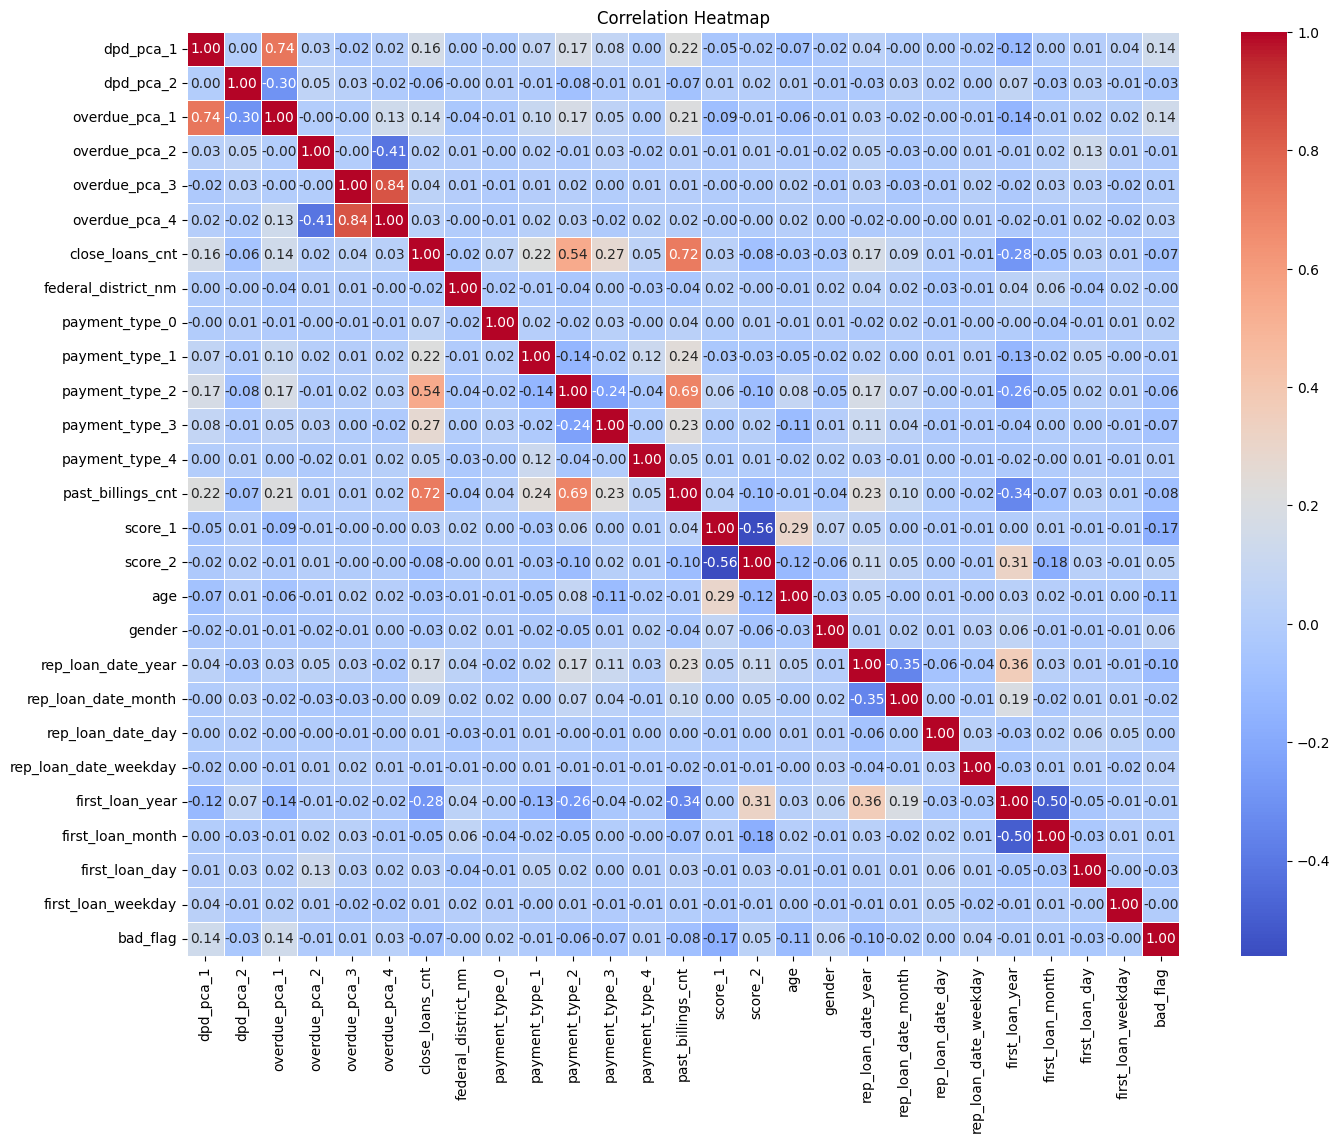

In [189]:
# Redo the heatmap
# Calculate the correlation matrix
correlation_matrix = df_new.corr()

# Create the heatmap
plt.figure(figsize=(16, 12))  # Adjust figsize for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

Skewness of dpd_pca_1: 4.230052152549657
Skewness of dpd_pca_2: -0.6960165094426873
Skewness of overdue_pca_1: 2.131355073920135
Skewness of overdue_pca_2: -0.5489425289744235
Skewness of overdue_pca_3: -0.09950217853561234
Skewness of overdue_pca_4: 1.8228872221638188
Skewness of close_loans_cnt: 4.391650711967688
Skewness of federal_district_nm: 0.14253409451363466
Skewness of payment_type_0: 30.267881050003318
Skewness of payment_type_1: 11.648236921684145
Skewness of payment_type_2: 1.5463406040399772
Skewness of payment_type_3: 4.978762706548587
Skewness of payment_type_4: 17.281121271363027
Skewness of past_billings_cnt: 1.2949804496832589
Skewness of score_1: -1.7244429430174286
Skewness of score_2: 3.812868098240167
Skewness of age: 0.733378746570181
Skewness of gender: 2.060972067611907
Skewness of rep_loan_date_year: -1.6495774968241699
Skewness of rep_loan_date_month: -0.39013954534968476
Skewness of rep_loan_date_day: -0.05710511359602891
Skewness of rep_loan_date_weekday: 

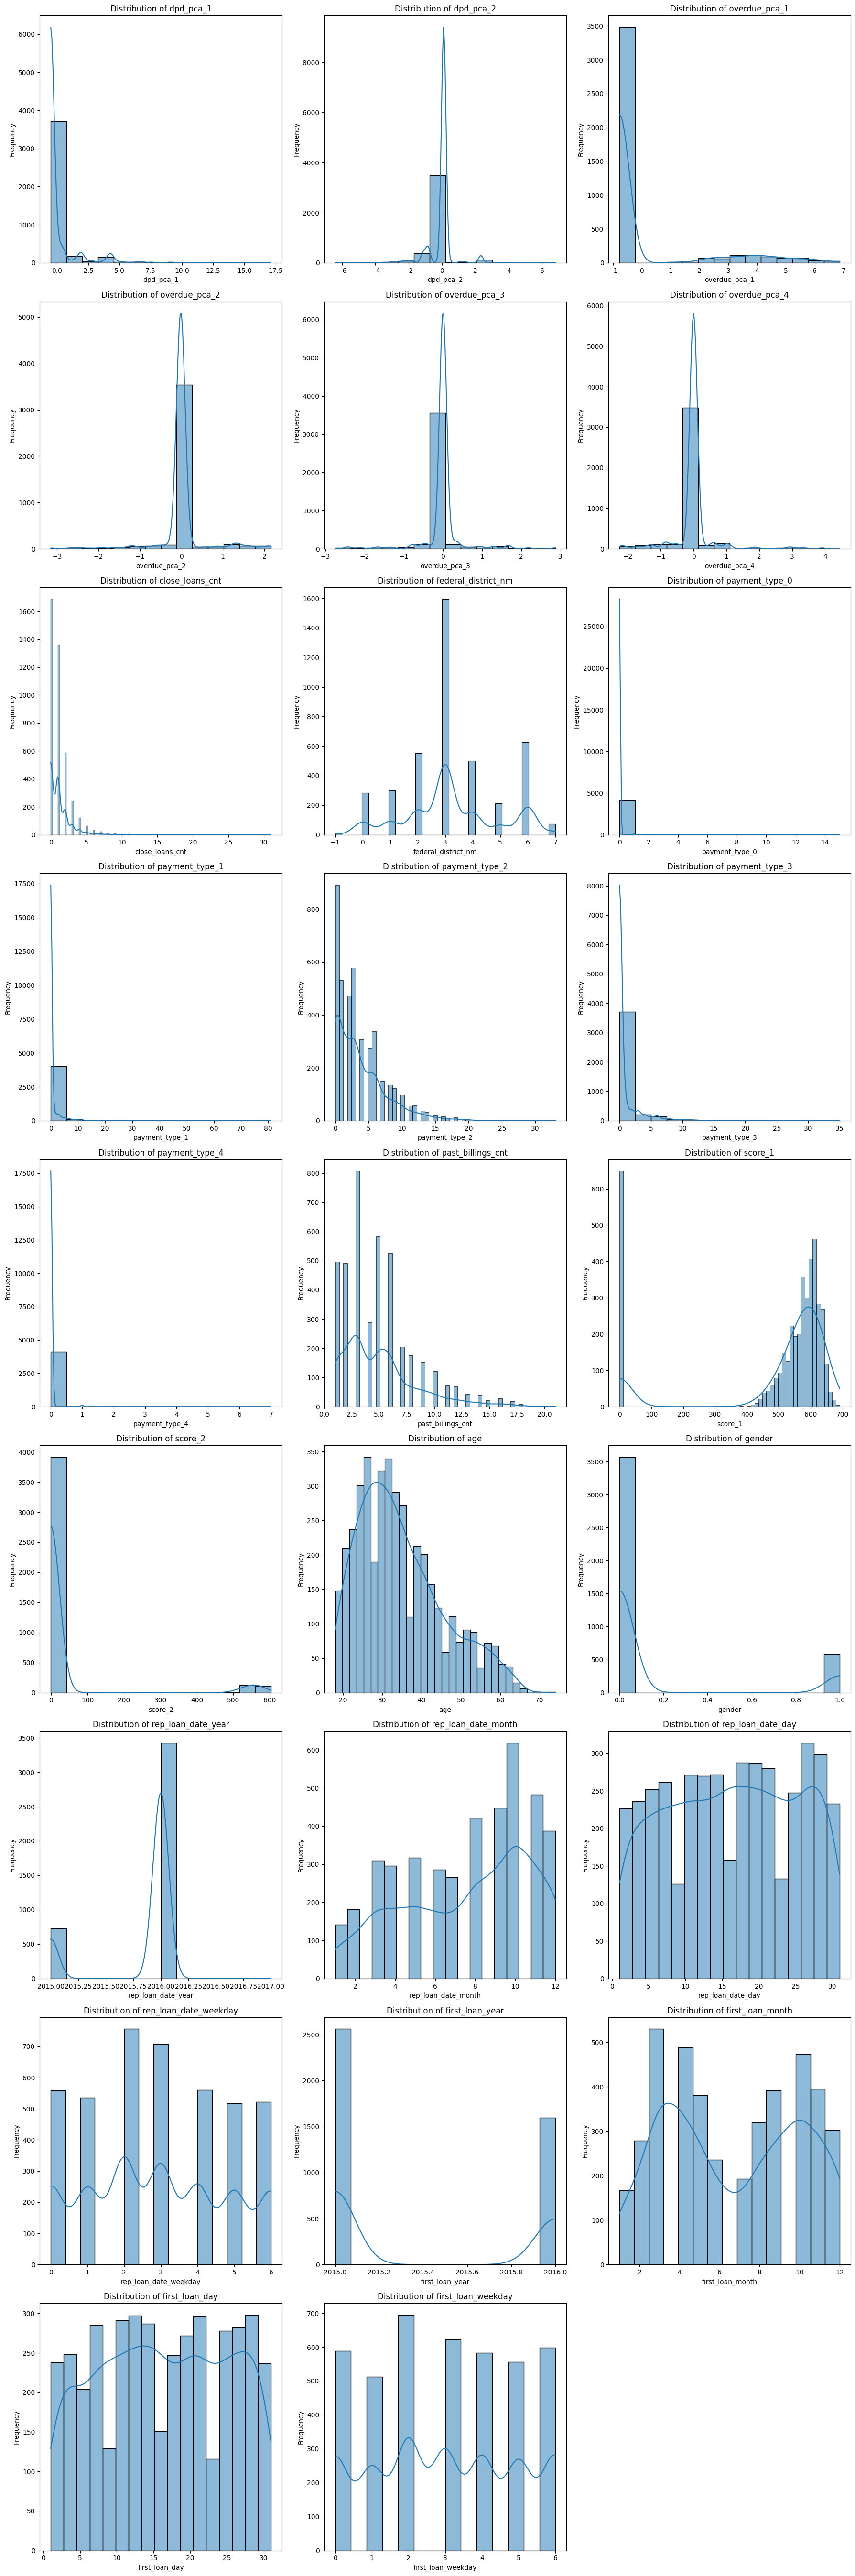

In [193]:
# Get numerical features (excluding the target variable)
numerical_features = df_new.select_dtypes(include=np.number).columns.tolist()
# numerical_features.remove('bad_flag')  # Remove the target variable

# Calculate the number of rows needed
num_features = len(numerical_features)
num_rows = (num_features + 2) // 3  # Calculate rows, add 2 for ceiling division

# Create subplots with 3 columns and calculated rows
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(18, num_rows * 6))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through features and plot on subplots
for i, feature in enumerate(numerical_features):
    sns.histplot(df_new[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

    # Check for skewness
    skewness = df_new[feature].skew()
    print(f"Skewness of {feature}: {skewness}")

# Hide any unused subplots
for i in range(num_features, num_rows * 3):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

    # Consider transformations based on skewness:
    # - If skewness is between -0.5 and 0.5, the data is approximately symmetric.
    # - If skewness is between -1 and -0.5 or between 0.5 and 1, the data is moderately skewed.
    # - If skewness is less than -1 or greater than 1, the data is highly skewed.

    # Example transformations:
    # - For right-skewed data (positive skewness), consider log transformation, square root transformation, or Box-Cox transformation.
    # - For left-skewed data (negative skewness), consider exponential transformation or reflection followed by a right-skewed transformation.

    # You can apply transformations using NumPy or pandas functions like np.log, np.sqrt, etc.
    # Remember to evaluate the impact of transformations on model performance.

Based on the feature distributions above, even if the skewnesses are so high just leave it be since the data has its context in its distribution, like the Age that only contains 0 or 1 (Can be mean Male or Female)

# **Let's Move To The Final Steps**

## 1. Data Preprocessing (2nd, and opt.)  
- **Handle Missing Values:**  
  Impute missing values using techniques like mean, median, mode, or advanced methods like KNN imputation. Pay attention to missing patterns that may indicate fraud.

- **Encode Categorical Variables:**  
  Apply one-hot encoding or label encoding for categorical features. Use target or frequency encoding for high-cardinality features if needed.

- **Scale/Normalize Features:**  
  Standardize numerical features using StandardScaler or MinMaxScaler for distance-based models (KNN, SVM). Tree-based models do not require scaling.

---

## 2. Handling Imbalanced Data  
Fraud detection datasets are typically imbalanced, with far fewer fraudulent transactions. Use the following techniques to address this:

- **Resampling Techniques:**  
  - **Oversampling:** Generate synthetic samples using SMOTE or ADASYN.  
  - **Undersampling:** Reduce the majority class size to balance the dataset.

- **Class Weights:**  
  Assign higher weights to the minority class when training models to handle imbalance effectively.

---

## 3. Feature Engineering  
- **Create New Features:**  
  Derive features based on transaction amounts, time intervals, user behavior, and frequency of events.

- **Feature Selection:**  
  Use correlation analysis, feature importance from tree-based models, or Lasso to select relevant features.

- **Feature Transformation:**  
  Apply transformations like log scaling or PCA to handle collinearity or reduce dimensionality.

---

## 4. Model Development  
- **Baseline Models:**  
  Train a simple Logistic Regression model as a baseline.

- **Advanced Models:**  
  Use tree-based models like Random Forest, XGBoost, or LightGBM. Consider ensemble methods to boost performance.

- **Cross-Validation:**  
  Use stratified k-fold cross-validation to evaluate model performance consistently.

---

## 5. Evaluation Metrics  
Since fraud detection focuses on identifying the minority class, prioritize these metrics:  
- **Precision, Recall, F1-Score**  
- **AUC-ROC Curve**  
- **Confusion Matrix** to analyze false positives and false negatives.

---

## 6. Hyperparameter Tuning  
Optimize model performance using GridSearchCV or RandomizedSearchCV. For efficiency, consider Bayesian optimization techniques.

In [194]:
# Rescale the data, with the exceptions the date that have been applied with PCA
from sklearn.preprocessing import StandardScaler

exclude_pca_data = ['dpd_pca_1', 'dpd_pca_2', 'overdue_pca_1', 'overdue_pca_2',
                    'overdue_pca_3']
# Select the numerical features to scale (excluding PCA components and target)
numerical_features_to_scale = [col for col in df_new.columns
                               if col not in exclude_pca_data + ['bad_flag']]

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the selected features and transform them
df_new[numerical_features_to_scale] = scaler.fit_transform(df_new[numerical_features_to_scale])

Let's start the training phase, handle the imbalanced data using Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples of the minority class (fraudulent transactions in `bad_flag` or target feature)

In [197]:
from imblearn.over_sampling import SMOTE

# Separate features (X) and target (y)
X = df_new.drop('bad_flag', axis=1)
y = df_new['bad_flag']

# Create a SMOTE object and resample the data
smote = SMOTE(random_state=42)  # You can adjust the random_state
X_resampled, y_resampled = smote.fit_resample(X, y)

Continue to train the data using all the model available and suitable, then compare it results

In [206]:
# Split the data first using train-test split in sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
label_encoder = LabelEncoder()
# Fit the encoder to your target variable and transform it
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)  # Transform y_test using the same encoder


# Make a function to use multiple models and metrics available
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates multiple models for fraud detection.

    Args:
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target.
        y_test: Testing target.

    Returns:
        A dictionary containing the trained models and their evaluation results.
    """

    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from xgboost import XGBClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import f1_score, classification_report, roc_auc_score

    positive_samples = sum(y_train == 1)
    scale_pos_weight = sum(y_train == 0) / positive_samples if positive_samples else 1
    # ^^^^^^^^^^ Set to 1 if positive_samples is 0 ^^^^^^^^^^^^^

    models = {
        "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
        "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
        "Support Vector Machine": SVC(class_weight='balanced', random_state=42),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    }

    results = {}

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model with multiple metrics
        report = classification_report(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        f1 = f1_score(y_test, y_pred, pos_label=1)

        results[model_name] = {
            "report": report,
            "auc": auc,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

    return results

# Evaluate the results
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Print the results
for model_name, result in results.items():
    print(f"--- {model_name} ---")
    print(result["report"])
    print(f"AUC: {result['auc']}\n")

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       762
           1       0.70      0.69      0.70       734

    accuracy                           0.70      1496
   macro avg       0.70      0.70      0.70      1496
weighted avg       0.70      0.70      0.70      1496

AUC: 0.7036856258090355

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       762
           1       0.94      0.94      0.94       734

    accuracy                           0.94      1496
   macro avg       0.94      0.94      0.94      1496
weighted avg       0.94      0.94      0.94      1496

AUC: 0.93918735294328

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       762
           1       0.97      0.91      0.94       734

    accuracy                           0.94      1496
   macro avg  

Based on the data above, it can be seen that XGBoost Model have the highest accuracy, and let's stick to that model to build the fraud detection model. <br>
Continue to use NN using TensorFlow to build the model.

In [210]:
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report, roc_auc_score


# 1. Extract Embeddings from XGBoost
positive_samples = sum(y_train == 1)
scale_pos_weight = sum(y_train == 0) / positive_samples if positive_samples else 1
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train, y_train)
X_train_embeddings = xgb_model.predict_proba(X_train)[:, 1]
X_test_embeddings = xgb_model.predict_proba(X_test)[:, 1]

# 2. Build and Compile the TensorFlow Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(1,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Transfer Learning and Evaluation
X_train_embeddings = X_train_embeddings.reshape(-1, 1)
X_test_embeddings = X_test_embeddings.reshape(-1, 1)
model.fit(X_train_embeddings, y_train, epochs=10, batch_size=32)

# Make predictions on the test set
y_pred = (model.predict(X_test_embeddings) > 0.5).astype(int) # Convert probabilities to binary predictions

# Evaluate the model with multiple metrics
report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f"--- TensorFlow with XGBoost Embeddings ---")
print(report)
print(f"AUC: {auc}\n")
print(f"Accuracy: {accuracy}\n")
print(f"Precision: {precision}\n")
print(f"Recall: {recall}\n")
print(f"F1 Score: {f1}\n")

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8166 - loss: 0.4787
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0292
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0043
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0032
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0029
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9982 - loss: 0.0044
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0023
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0028
Epoch 9/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0038
Epoch 10/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 9.7939e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
--- TensorFlow with XGBoost Embeddings ---
              precision    recall  f1-score   support

Compare the result of Ordinary XGB and TF with XGB Embeddings

In [209]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': ['Ordinary XGBoost', 'TensorFlow with XGBoost Embeddings'],
    'Accuracy': [results['XGBoost']['accuracy'], accuracy],
    'Precision': [results['XGBoost']['precision'], precision],
    'Recall': [results['XGBoost']['recall'], recall],
    'F1-Score': [results['XGBoost']['f1_score'], f1],
    'AUC': [results['XGBoost']['auc'], auc]
})

# Display the results DataFrame
display(results_df)

# Optional: Highlight the best performing model for each metric
results_df.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'], color='lightgreen', axis=0)

Model  Accuracy  Precision    Recall  \
0                    Ordinary XGBoost  0.944519   0.972424  0.912807   
1  TensorFlow with XGBoost Embeddings  0.937834   0.939643  0.933243   

   F1-Score       AUC  
0  0.941673  0.943936  
1  0.936432  0.937750

Based on the data above, the standard XGBoost model significantly outperforms the neural network model built with TensorFlow and XGBoost embeddings. Therefore, selecting the **XGBoost model** for fraud detection using the data in this notebook appears to be a wise decision. 😊